# Version notes:

Subversions:
- d: 
    - go big: up to 120 days before departure
        - need to update date_df in HDFS
    - iterate over markets & save figs
- c: remove missing search days
    - there is a gap in search data / dates (missing 8/15-8/18). Assume if an entire day is missing, this isn't a data coverage issue -- it was a dev system issue
- b: add in cross-join with dates, markets, etc
- a: EDA, dev approach


Notebook series 04x:
- take a broader view of "coverage"
    - data across sliding window of shopping days
    - how does "coverage" change (improve) as we get closer to travel dates?

General:
- uses `shop_vol` input data -- data aggregated specifically to look at shopping volume (and by extension its presence / absence)
    - previous versions had used data aggregated for lowest fare analysis

In [1]:
from functools import reduce
import datetime
from calendar import Calendar
import argparse

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

In [2]:
# for notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

In [3]:
# =============================

# VARIABLES & ARGUMENTS
# ----------------

input_dir = "/user/kendra.frederick/shop_vol/encoded/markets/v2"
date_enum_path = "/user/kendra.frederick/shop_grid/date-cross_120"
APP_NAME = "KF-ShopGrid-Jupyter"

In [4]:
# SET UP SPARK
# ----------------
run_mode = "python" 

if run_mode == "python":
    conf1 = pyspark.SparkConf().setAll([
        ("spark.app.name", APP_NAME),
#         ("spark.master","yarn"),
        ("spark.driver.memory","20g"),
#         ("spark.executor.memory", "10g"),
#         ("spark.executor.instances", 5),
#         ("spark.executor.cores", "5"),
        ('spark.sql.crossJoin.enabled', True),
        ('spark.sql.shuffle.partitions', 8) # added this after
        ])
    spark = SparkSession.builder.config(conf = conf1).getOrCreate()
elif run_mode == "spark-submit":
    spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
else:
    pass

In [5]:
spark.sparkContext.applicationId

'local-1662049817843'

# enumerate dates / durations

New: develop rolling-window approach to search & travel dates

added this back in & modified

Much trouble doing this.
- can't run distributed
    - Python3 version mis-match between workers & driver
- run this notebook in local mode
    - OOM (??)
- create cross_df in python2 via CLI on a dev machine, save to HDFS, and load here

In [6]:
import datetime

# vars that could be params
max_days_til_dept = 120
max_stay_duration = 30

shop_start_str = "2022-08-01" 
shop_end_str = "2022-08-25" 

missing_search_days_str = ["2022-08-15", "2022-08-16", "2022-08-17", "2022-08-18"]

# SEARCH DATES
search_start = datetime.datetime.strptime(shop_start_str, "%Y-%m-%d").date()
search_end = datetime.datetime.strptime(shop_end_str, "%Y-%m-%d").date()
num_search_days = (search_end - search_start).days + 1
missing_search_days_dt = [datetime.datetime.strptime(x, "%Y-%m-%d").date() 
                          for x in missing_search_days_str]
search_date_list = [search_start + datetime.timedelta(days=x) for x in range(num_search_days)]
search_date_list_filt = [x for x in search_date_list if x not in missing_search_days_dt]

search_date_data = [(x, ) for x in search_date_list_filt]
search_date_df = spark.createDataFrame(
    data=search_date_data, schema=["searchDt_dt"]
)
search_date_df = search_date_df.coalesce(1)

# STAY DURATION
stay_duration_data = [(x, ) for x in range(max_stay_duration)]
stay_dur_df = spark.createDataFrame(
    data=stay_duration_data, schema=["stay_duration"])

# OUTBOUND DEPARTURE DATES
min_dept_dt = search_start #+ datetime.timedelta(days=1) # filters out same-day searches; include them?
max_dept_dt = search_end + datetime.timedelta(days=max_days_til_dept)
max_return_dt = max_dept_dt + datetime.timedelta(days=max_stay_duration)

num_days = (max_dept_dt - min_dept_dt).days
dept_date_list = [min_dept_dt + datetime.timedelta(days=x) for x in range(num_days)]
dept_date_data = [(x, ) for x in dept_date_list]
dept_date_df = spark.createDataFrame(
    data=dept_date_data, schema=["outDeptDt_dt"])
dept_date_df = dept_date_df.coalesce(1)

# # CROSS-JOIN
# cross_df1 = (dept_date_df.crossJoin(stay_dur_df))
# date_cross_df = (cross_df1.crossJoin(search_date_df))
# date_cross_df = date_cross_df.repartition(6, "searchDt_dt")

In [7]:
date_cross_df = spark.read.parquet(date_enum_path)

# load data

In [8]:
# load markets to analyze
markets_path = "/user/kendra.frederick/shop_grid/markets.csv"
markets_df = spark.read.csv(markets_path, header=True)
print("Analyzing {} markets".format(markets_df.count()))

temp = markets_df.select("market_key_decoded").collect()
market_list = [x["market_key_decoded"] for x in temp]

markets_df = markets_df.withColumnRenamed("market_key_decoded", "market")

Analyzing 37 markets


In [9]:
df = spark.read.parquet(input_dir)
df = df.withColumn("market", 
    F.concat_ws("-", F.col("origin_decoded"), F.col("dest_decoded")))

# In a perfect world, shouldn't need to do this; input data is derived from markets.
# However, this list has been changed, so join vs. current list 
# to "clean up" input data
df_join = df.join(F.broadcast(markets_df), on="market", how="inner")

# convert Dept dates (which are strings) to datetime
df_join.registerTempTable("data")
df_join = spark.sql("""
    SELECT *,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(outDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS outDeptDt_dt,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(inDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS inDeptDt_dt,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(searchDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS searchDt_dt
    FROM data
""")

# filter on dates & round-trip
df_filt = (df_join
            .filter(F.col("outDeptDt_dt").between(min_dept_dt, max_dept_dt))
           # don't need to do this
#             .filter(F.col("searchDt_dt") >= search_start)
#             .filter(F.col("searchDt_dt") <= search_end)
            # Note: when we filter on stay duration below, this also
            # effectively accomplishes filtering on round-trip == 1
            .filter(F.col("round_trip") == 1)
        )

# group by market and count shops
cnt_df = (df_join
            .groupBy(["market", 
                        "searchDt_dt", "outDeptDt_dt", "inDeptDt_dt", # "round_trip"
                        ])
            .agg(
                F.sum("solution_counts").alias("sum_solution_counts"),
                F.sum("shop_counts").alias("sum_shop_counts")
            )
            .withColumn("shop_ind", F.lit(1)) # add an indicator column
            )

cnt_df = cnt_df.withColumn('stay_duration',
                F.datediff(
                    F.col('inDeptDt_dt'), F.col('outDeptDt_dt'))
                )

# Note this effectively filters out null stay durations, which are one-way trips
cnt_df = cnt_df.filter(F.col('stay_duration').between(0, max_stay_duration))

# MOVE CALCS & FILTERS TO OCCUR AFTER CROSS JOIN?
# cnt_df = cnt_df.withColumn('days_til_dept',
#                 F.datediff(
#                     F.col('outDeptDt_dt'), F.col('searchDt_dt'))
#                 )

# # could filter instead on max_return_df
# cnt_df = cnt_df.filter(F.col('days_til_dept').between(0, max_days_til_dept))

cnt_df.repartition("market")

DataFrame[market: string, searchDt_dt: date, outDeptDt_dt: date, inDeptDt_dt: date, sum_solution_counts: bigint, sum_shop_counts: bigint, shop_ind: int, stay_duration: int]

In [10]:
cnt_df.show(5)

+-------+-----------+------------+-----------+-------------------+---------------+--------+-------------+
| market|searchDt_dt|outDeptDt_dt|inDeptDt_dt|sum_solution_counts|sum_shop_counts|shop_ind|stay_duration|
+-------+-----------+------------+-----------+-------------------+---------------+--------+-------------+
|LHR-IST| 2022-08-20|  2022-09-04| 2022-09-11|             108726|           1079|       1|            7|
|BKK-ICN| 2022-08-20|  2022-09-21| 2022-10-01|              39496|            201|       1|           10|
|SIN-BKK| 2022-08-20|  2022-12-01| 2022-12-04|             123148|            501|       1|            3|
|LHR-BKK| 2022-08-20|  2022-11-15| 2022-12-03|               1768|             30|       1|           18|
|LHR-JFK| 2022-08-20|  2022-08-24| 2022-08-27|             162850|            412|       1|            3|
+-------+-----------+------------+-----------+-------------------+---------------+--------+-------------+
only showing top 5 rows



In [11]:
# cnt_df.count()

# iter over markets & save figures

In [12]:
# where to save figures
out_dir = "./output/04/120-days/"

In [14]:
# from 04c notebook
def process(market, input_df, window_size=3):
    mrkt_df = input_df.filter(F.col("market") == market)


    join_cols = ['outDeptDt_dt', 'stay_duration', 'searchDt_dt']

    # join with enum date df
    mrkt_join_df = (mrkt_df.join(date_cross_df, 
                                on=join_cols, 
                                how='outer')
                        .fillna(0, subset=['sum_solution_counts', 'sum_shop_counts', 'shop_ind'])
                )

    # calculate `days_til_dept`
    mrkt_join_df = mrkt_join_df.withColumn('days_til_dept',
                    F.datediff(
                        F.col('outDeptDt_dt'), F.col('searchDt_dt'))
                    )

    # And then filter on it
    mrkt_join_df = mrkt_join_df.filter(F.col('days_til_dept').between(0, max_days_til_dept))

    window = (Window.partitionBy('outDeptDt_dt', 'stay_duration')
    #                 .orderBy('searchDt_long')
    #                 .rangeBetween(-sec_in_day(window_size-1), 0)
                    .orderBy('searchDt_dt')
                    .rowsBetween(-(window_size-1), Window.currentRow)
            )

    market_window_df = (mrkt_join_df
            .withColumn("sum_solutions_window", F.sum("sum_solution_counts").over(window))
            .withColumn("num_shop_days_window", F.sum("shop_ind").over(window))
            .withColumn("avg_solutions_window", F.mean("sum_solution_counts").over(window))
            .withColumn("avg_shop_days", F.mean("shop_ind").over(window))
            )

    # add this for filtering out the first rows in a window, which don't have complete aggregates
    # Note: can't have restriction on rowsBetween for row_number calc
    # so must do as a separate window calc
    window2 = (Window.partitionBy('outDeptDt_dt', 'stay_duration')
                    .orderBy('searchDt_dt')
            )

    market_window_df2 = (market_window_df
                .withColumn("grp_num", F.row_number().over(window2))         
            )

    market_window_df2 = market_window_df2.filter(F.col("grp_num") >= window_size)

    # send to Pandas for plotting
    market_pdf = market_window_df2.toPandas()

    return market_pdf

def agg_and_plot(market, market_pdf, save_fig=False):
    # mrkt_clip_pdf = mrkt_pdf[mrkt_pdf['grp_num'] >= window_size]
    market_agg_pdf = (market_pdf
                    .groupby(["days_til_dept", "stay_duration"])
                    .agg({"shop_ind": "sum", 
                            "avg_shop_days": "mean",
                            "sum_solution_counts": ["sum", "mean"]
                        })
                    )
    market_agg_pdf.columns = ["num_shop_days", "avg_pct_coverage_shop", "total_num_solutions", "avg_num_solutions"]
    market_agg_pdf = market_agg_pdf.reset_index()

    market_agg_pdf3 = (market_pdf
                    .groupby(["outDeptDt_dt", "stay_duration"])
                    .agg({"shop_ind": "sum", 
                            "avg_shop_days": "mean",
                            "sum_solution_counts": ["sum", "mean"]
                        })
                    )
    market_agg_pdf3.columns = ["num_shop_days", "avg_pct_coverage_shop", "total_num_solutions", "avg_num_solutions"]
    market_agg_pdf3 = market_agg_pdf3.reset_index()

    pvt1 = market_agg_pdf.pivot(index="stay_duration", 
                            columns="days_til_dept", 
                            values="num_shop_days")

    pvt2 = market_agg_pdf.pivot(index="stay_duration", 
                            columns="days_til_dept", 
                            values="avg_pct_coverage_shop")

    pvt3 = market_agg_pdf3.pivot(index="stay_duration", 
                            columns="outDeptDt_dt", 
                            values="num_shop_days")

    pvt4 = market_agg_pdf3.pivot(index="stay_duration", 
                           columns="outDeptDt_dt", 
                           values="avg_pct_coverage_shop")

    # fig, _ = plt.subplots(2,1, figsize=(12, 10))

    file_name = (market + "_shop_" + shop_start_str + "_" + shop_end_str 
                + "_travel_" + str(max_days_til_dept) + "-days")

    fig1, _ = plt.subplots(2,1, figsize=(max_days_til_dept//5, (max_stay_duration//6)*2))

    with sns.axes_style("white"):
        plt.subplot(2,1,1)
        sns.heatmap(pvt3, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'label': 'num shop days',
                            'shrink': 0.5});
        plt.title("Num shop days");
        plt.ylabel("stay duration (days)")
        plt.xlabel("");

    with sns.axes_style("white"):
        plt.subplot(2,1,2)
        sns.heatmap(pvt4, cmap='Greens', square=True,
                    vmin=0, vmax=1.0,
                    cbar_kws={'label': 'avg % coverage (shop days)',
                            'shrink': 0.5});
        plt.title("Average % Coverage - rolling 3-day window");
        plt.ylabel("stay duration (days)")
        plt.xlabel("departure date");

    fig1.suptitle(market)
    fig1.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.4)
    fig1.show()

    if save_fig:
        plt.savefig(out_dir + file_name + "_by-dept-date.png", format="png")


    fig2, _ = plt.subplots(2,1, figsize=(max_days_til_dept//5, (max_stay_duration//6)*2))
        
    with sns.axes_style("white"):
        plt.subplot(2,1,1)
        sns.heatmap(pvt1, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'label': 'number days w/ a shop',
                            'shrink': 0.5});
        plt.title("Total num shop days");
        plt.ylabel("stay duration (days)")
        plt.xlabel("days until departure");

    with sns.axes_style("white"):
        plt.subplot(2,1,2)
        sns.heatmap(pvt2, cmap='Greens', square=True,
                    vmin=0, vmax=1.0,
                    cbar_kws={'label': 'avg % coverage',
                            'shrink': 0.5});
        plt.title("Average % Coverage - rolling 3-day window of shopping");
        plt.ylabel("stay duration (days)")
        plt.xlabel("days until departure");
        

    fig2.suptitle(market)
    fig2.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.3)
    fig2.show()

    if save_fig:
        plt.savefig(out_dir + file_name + "_by-days-til-dept.png", format="png")

In [ ]:
market = 'JFK-LHR'
mpdf = process(market, cnt_df)

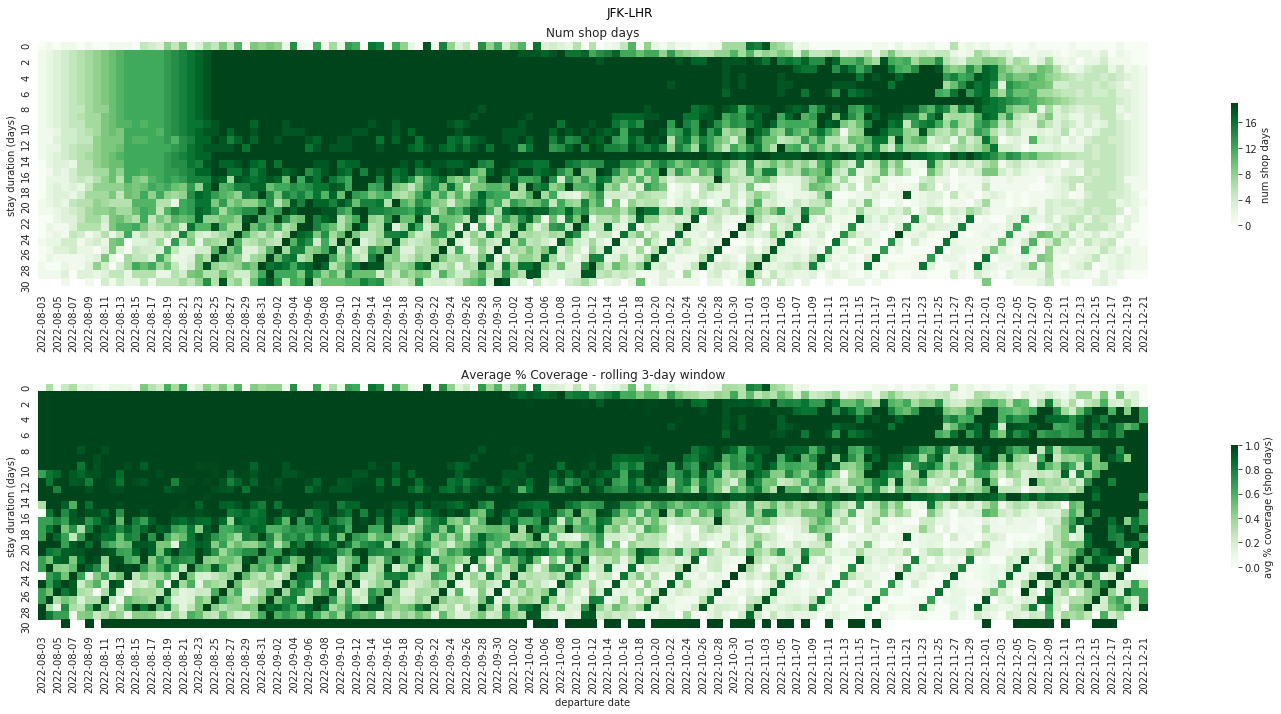

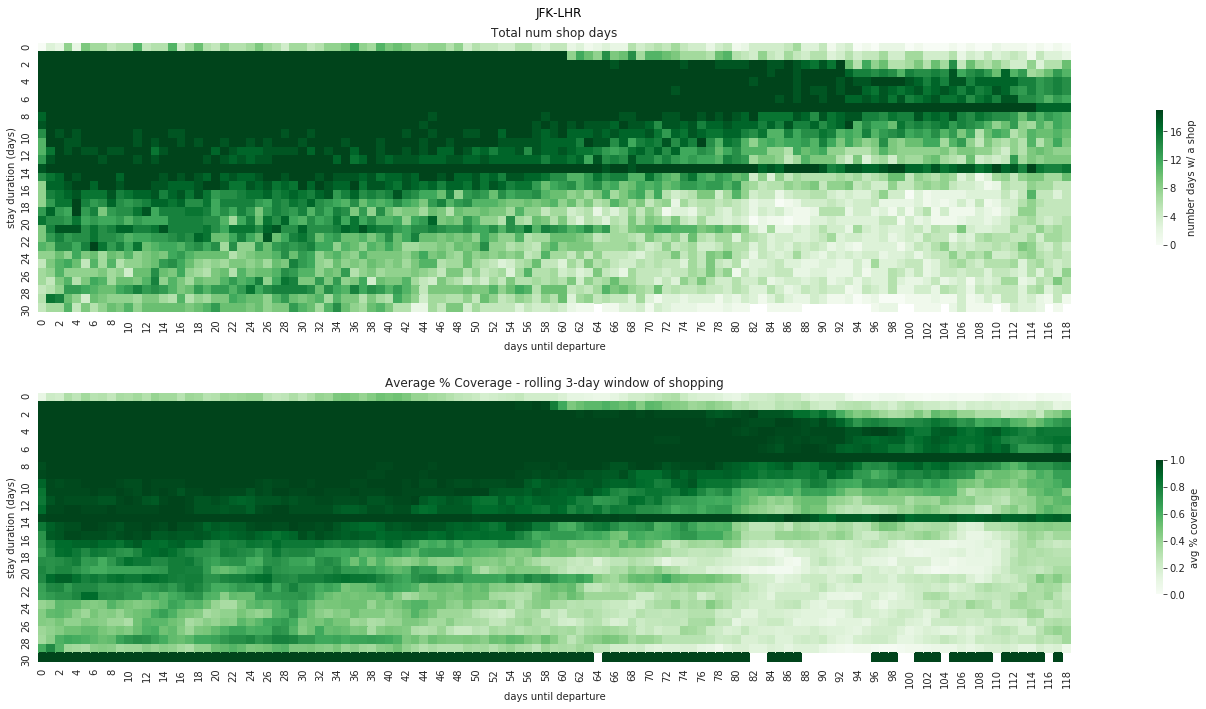

In [17]:
agg_and_plot(market, mpdf, True)

better

In [18]:
markets_to_plot = [
    'LHR-JFK',
    'DFW-ORD',
    'JFK-LAX',
    'BKK-SIN',
    'DEL-BOM',
    'SYD-MEL',
    'LHR-BKK',
    'LHR-DOH',
]

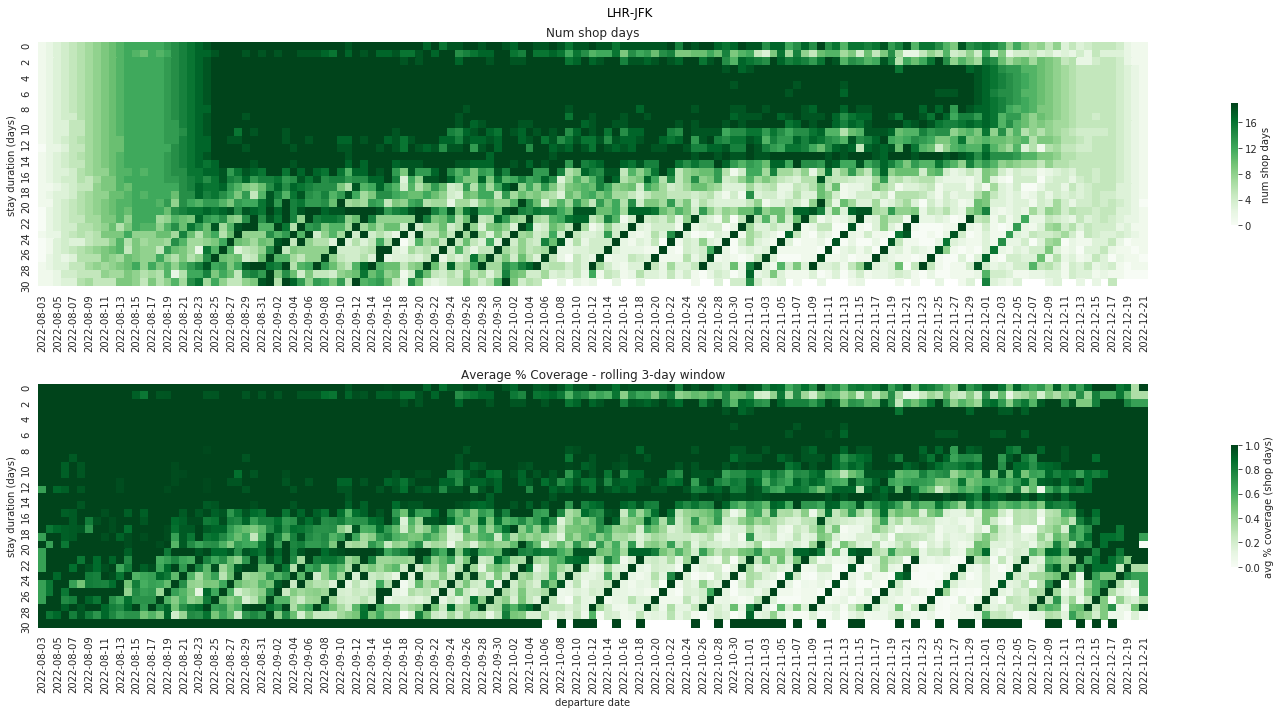

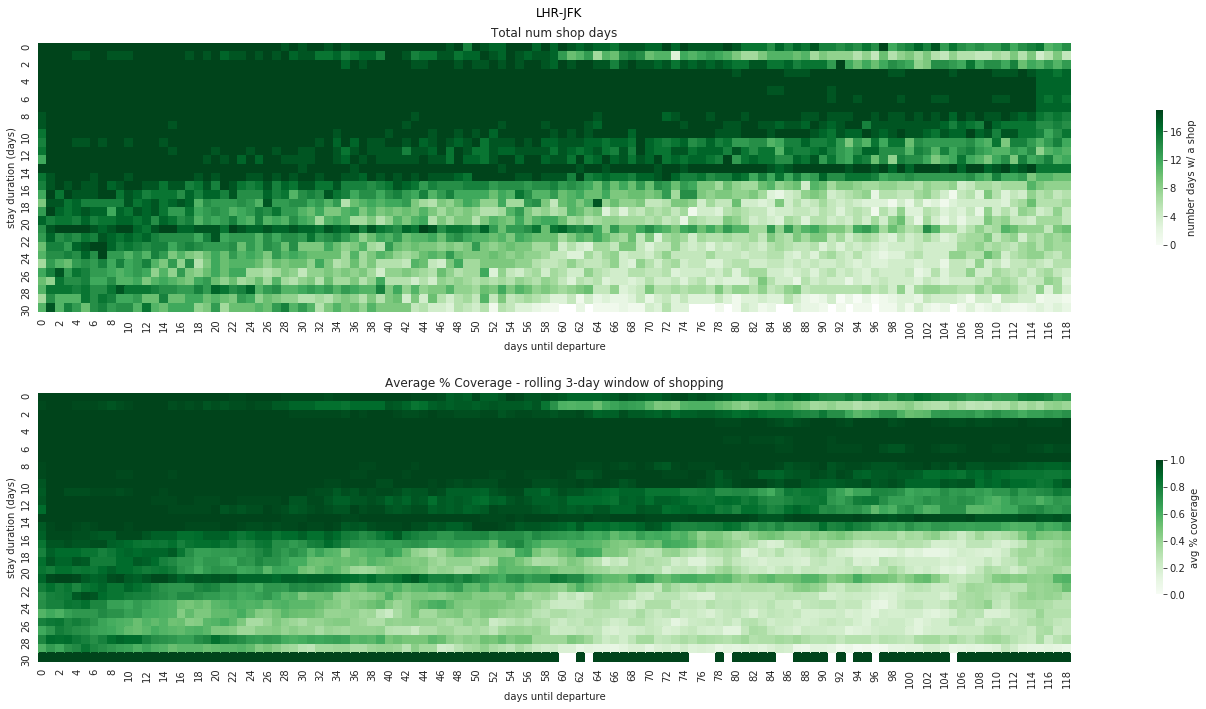

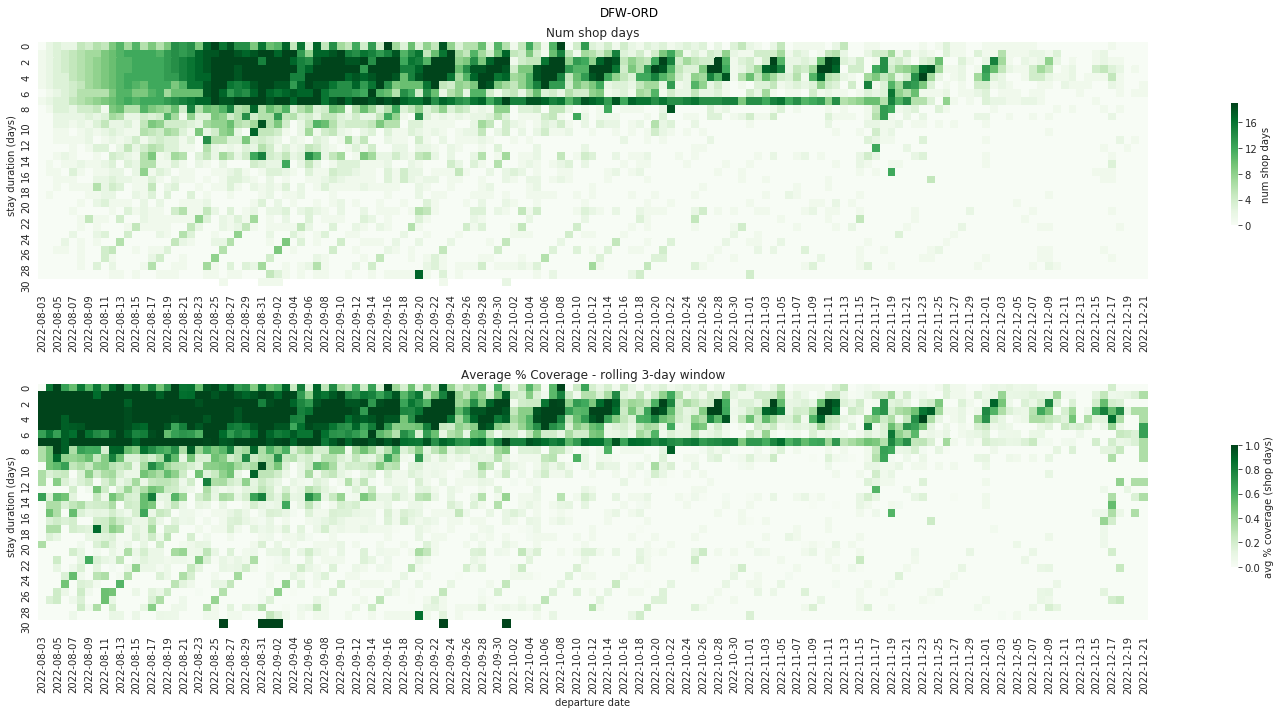

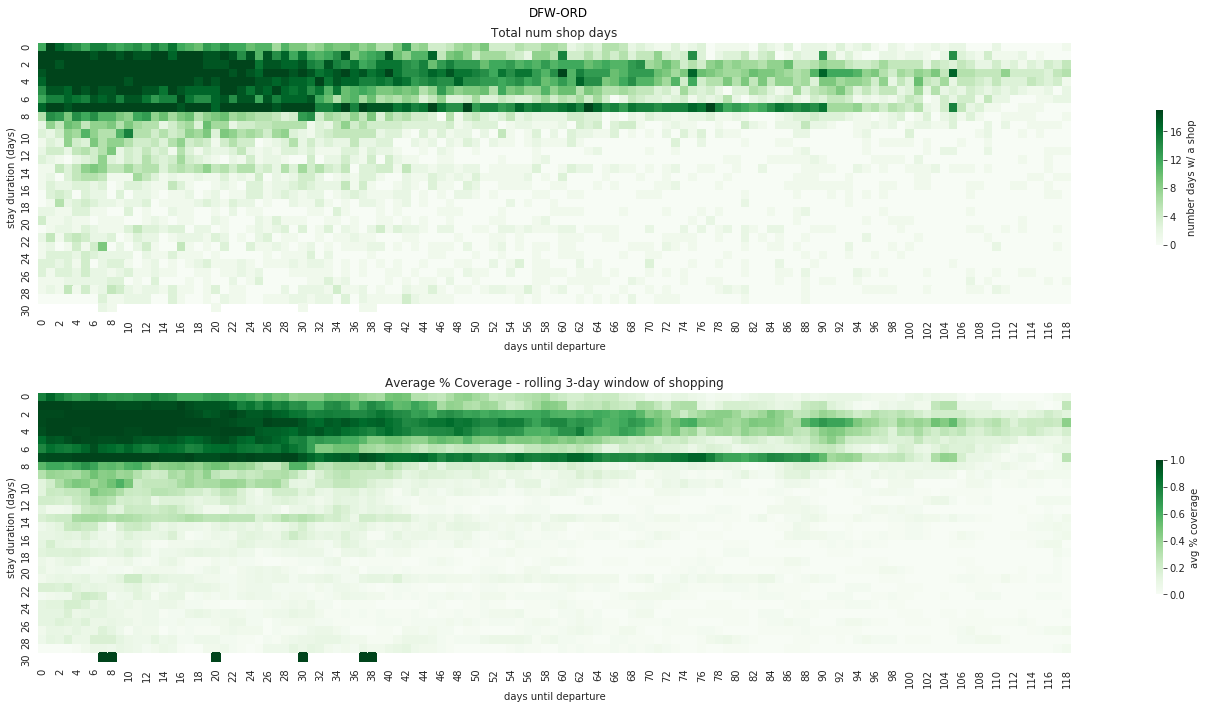

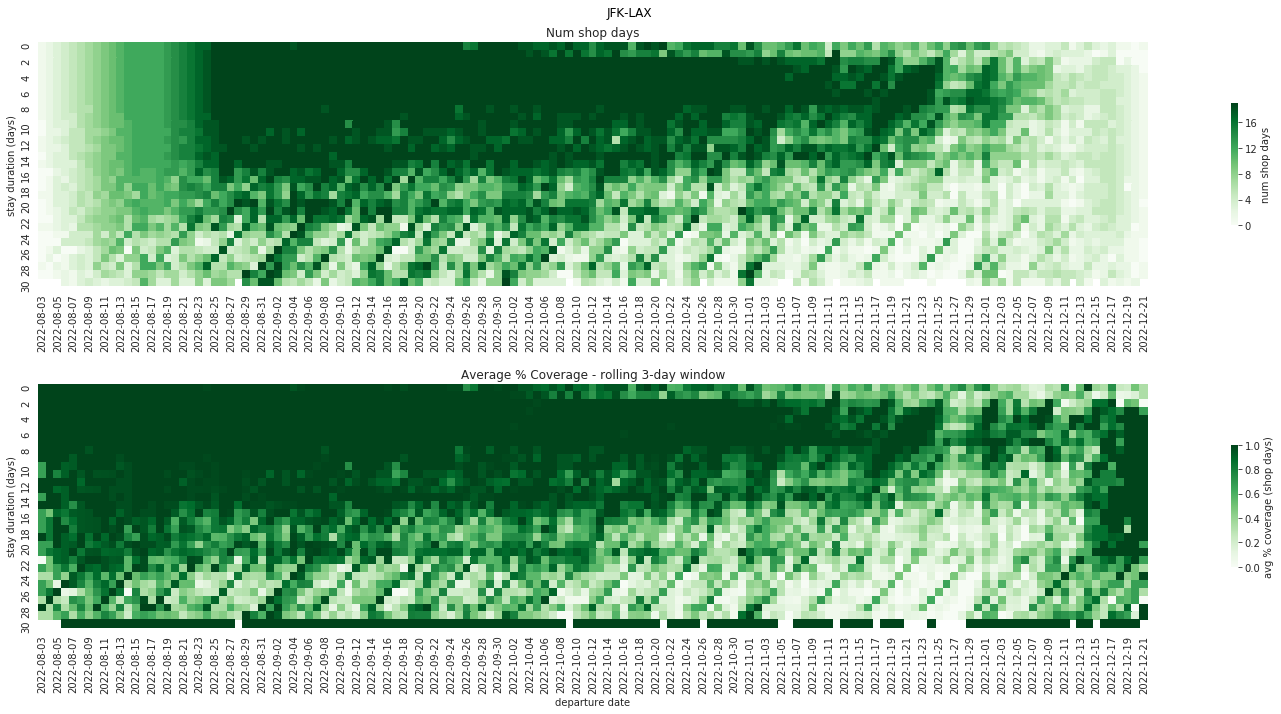

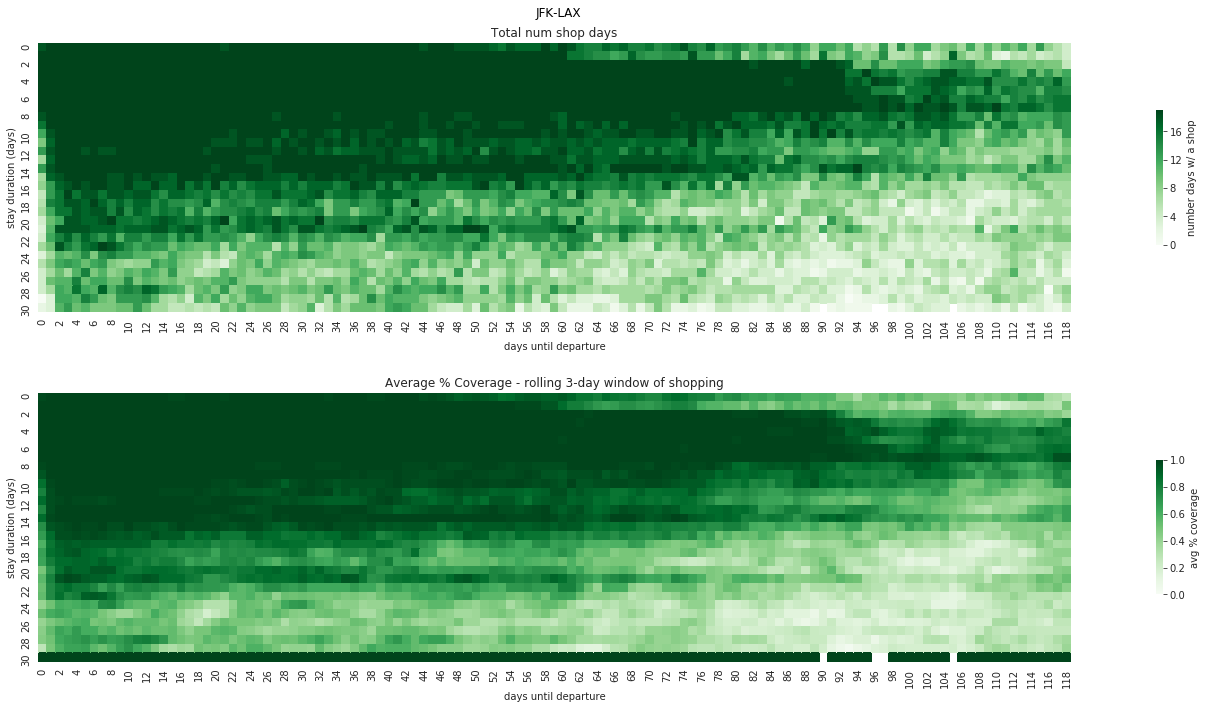

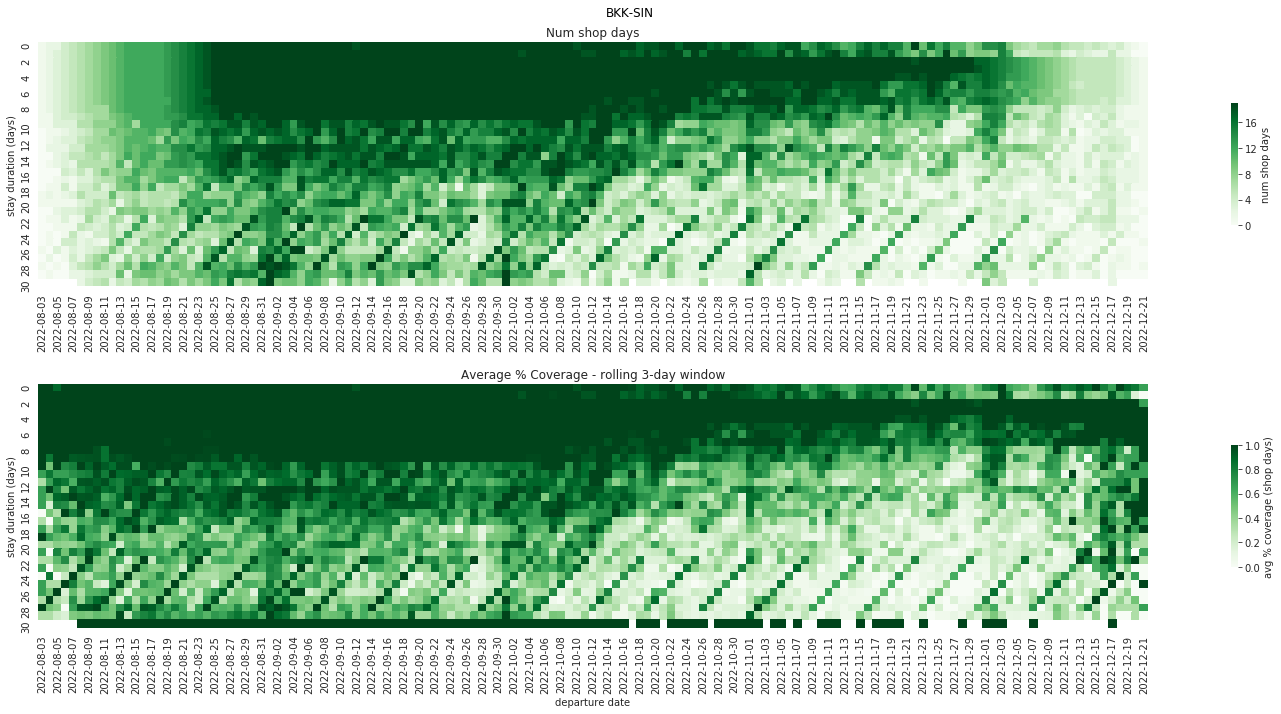

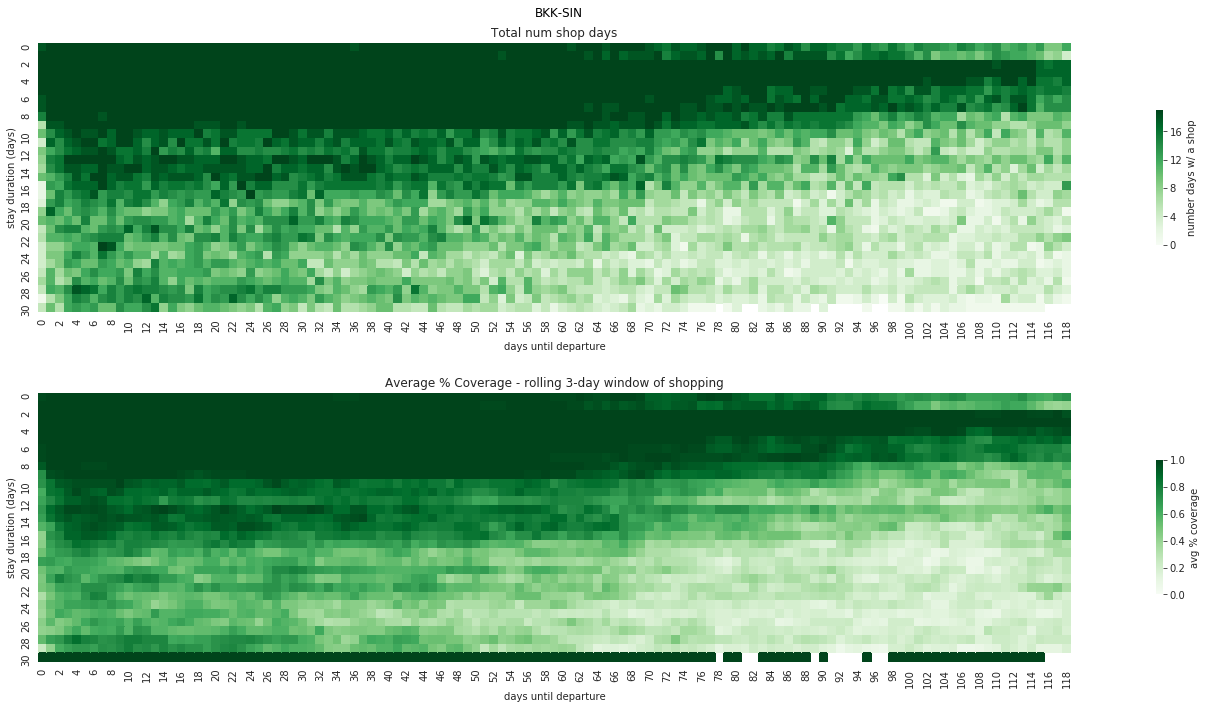

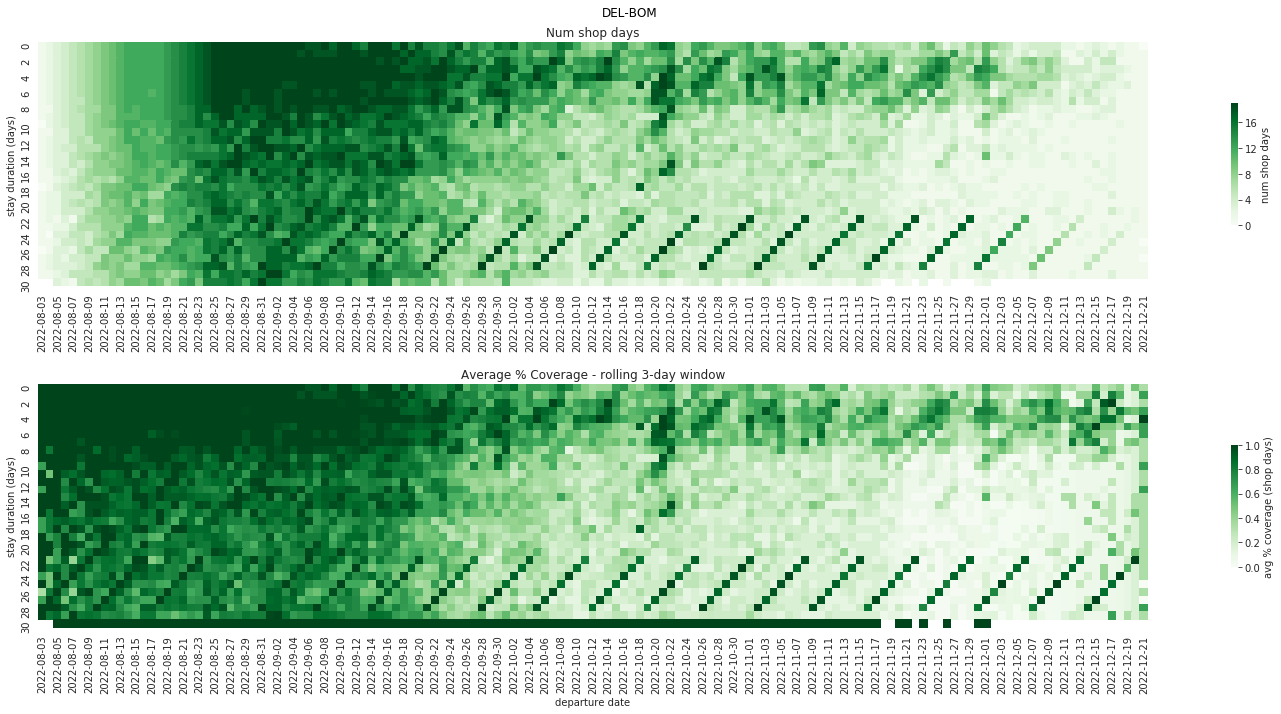

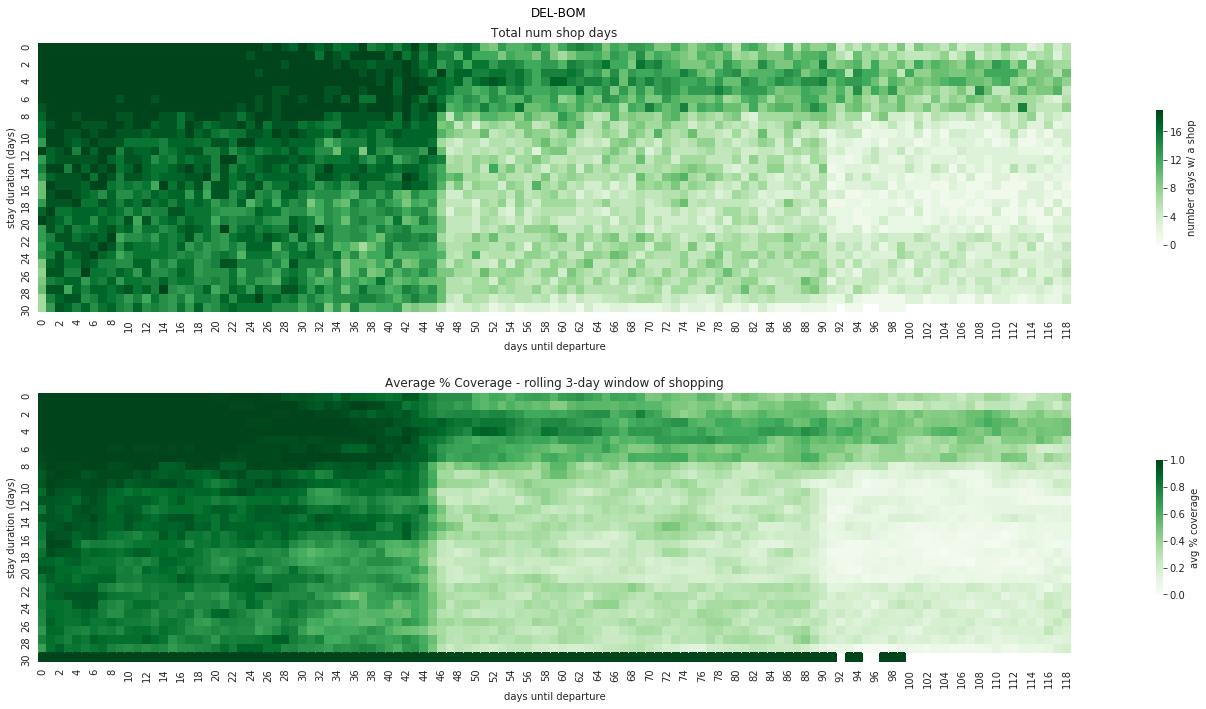

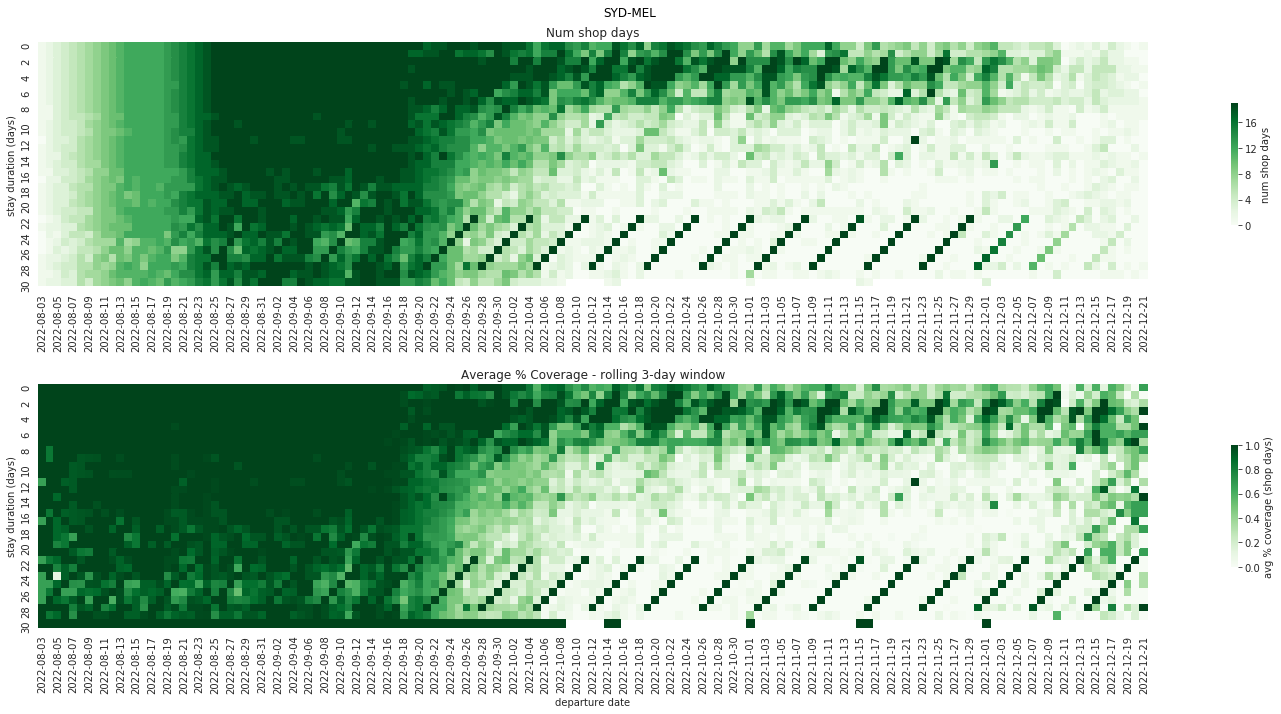

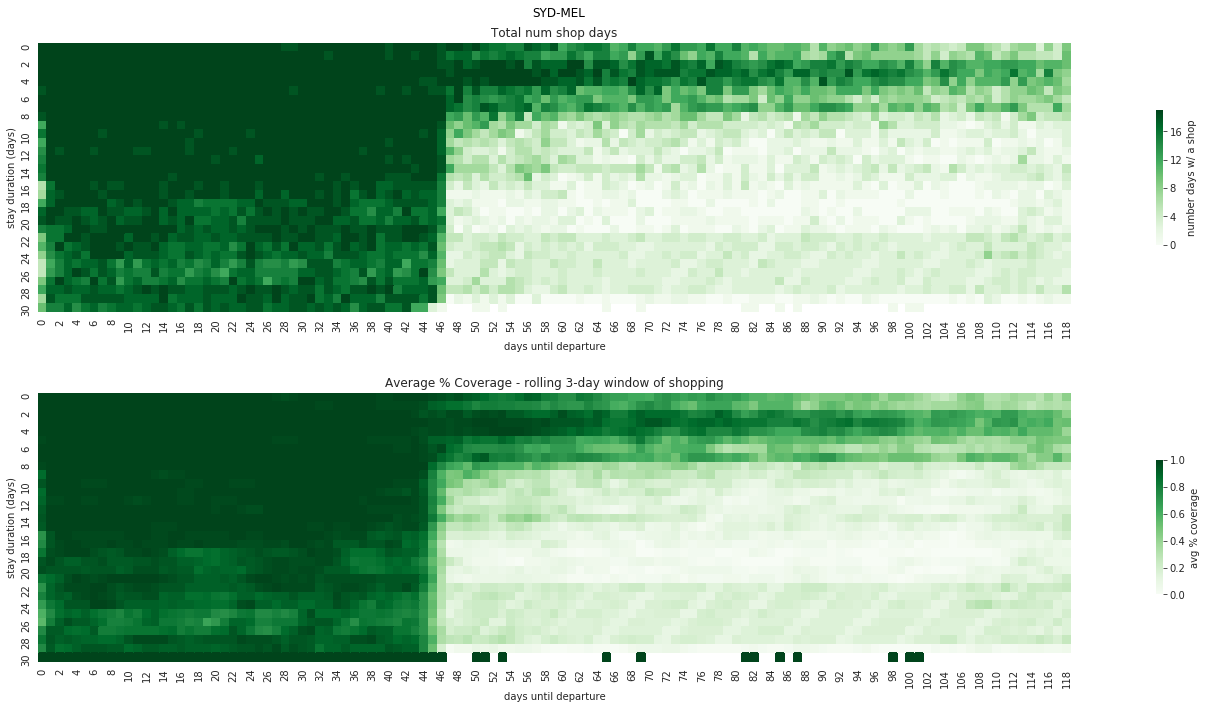

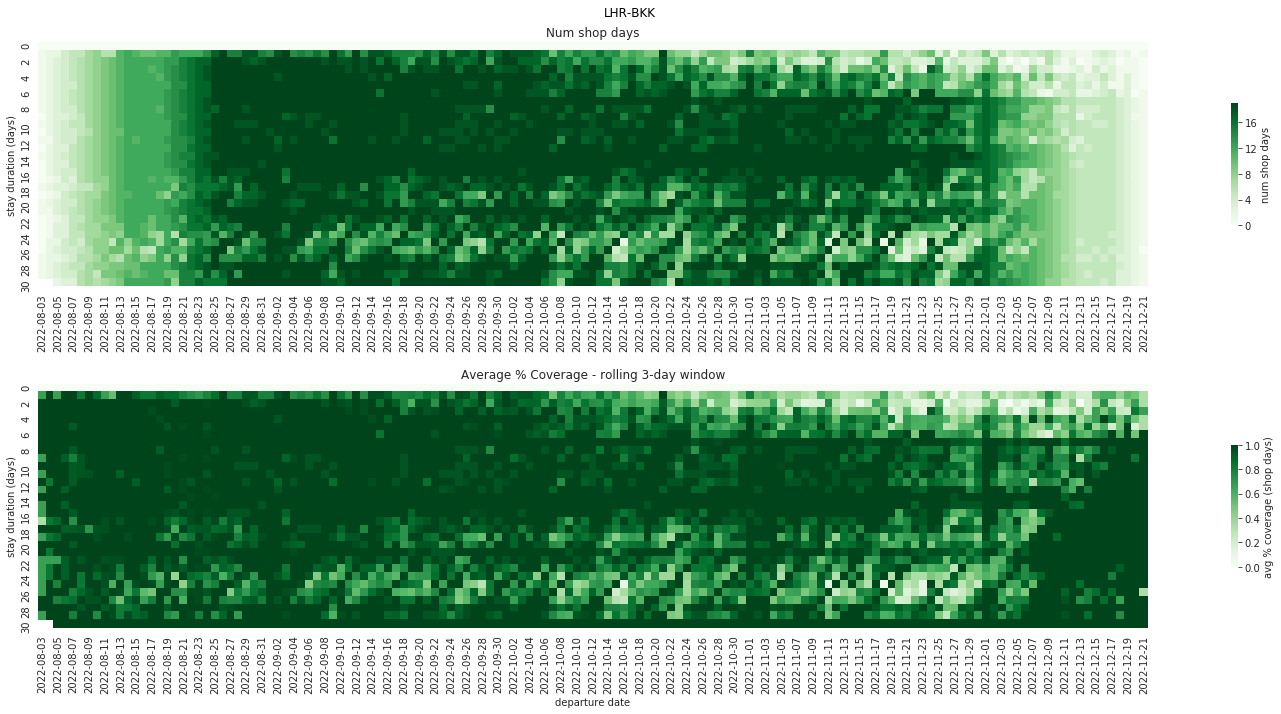

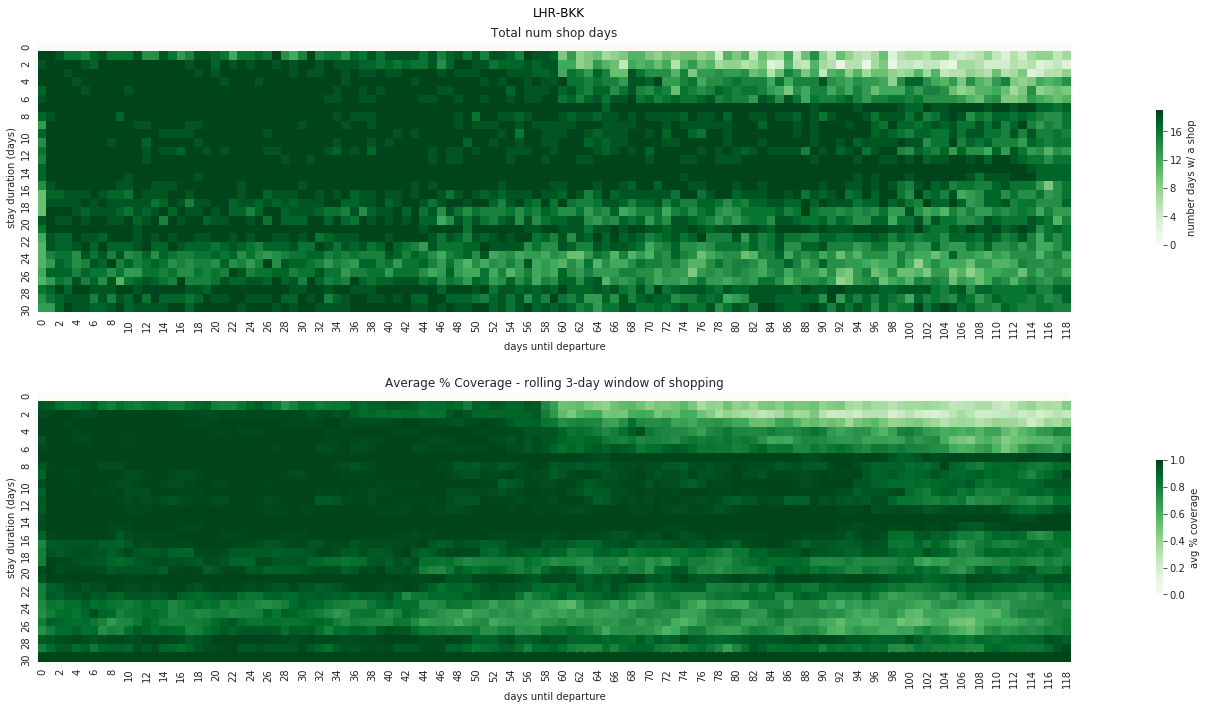

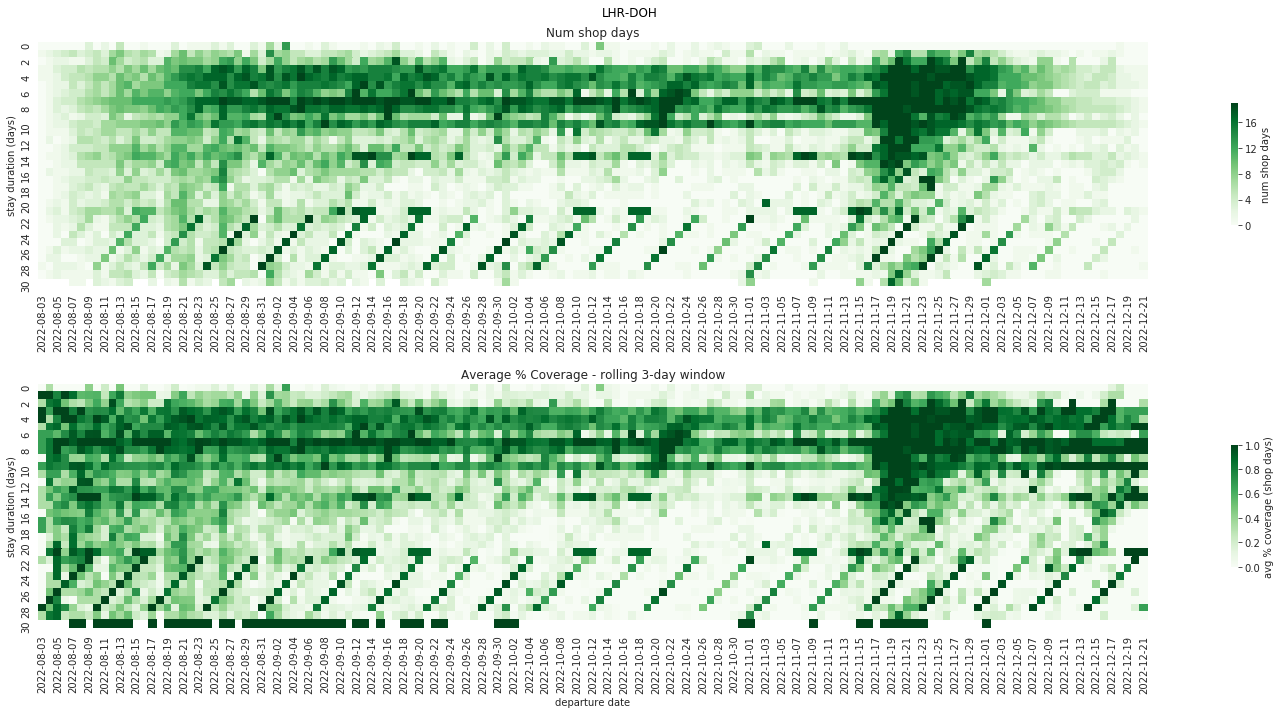

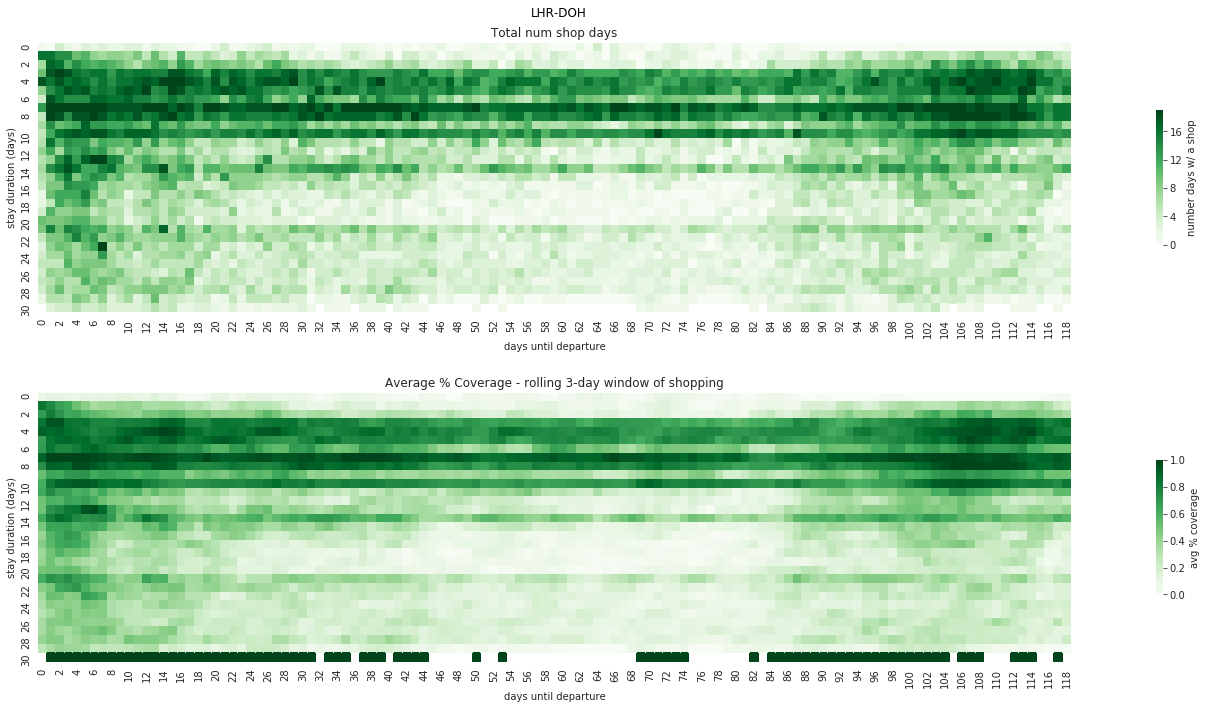

In [19]:
for market in markets_to_plot:
    mpdf = process(market, cnt_df)
    agg_and_plot(market, mpdf, True)

In [ ]:
spark.stop()

# dev volume plots

In [ ]:
mpdf.head()

In [15]:
market = 'LHR-JFK'
mpdf = process(market, cnt_df)

In [16]:
mpdf.head()

,outDeptDt_dt,stay_duration,searchDt_dt,market,inDeptDt_dt,sum_solution_counts,sum_shop_counts,shop_ind,days_til_dept,sum_solutions_window,num_shop_days_window,avg_solutions_window,avg_shop_days,grp_num
0,2022-08-03,27,2022-08-03,None,None,0,0,0,0,2837,2,945.666667,0.666667,3
1,2022-08-04,9,2022-08-03,LHR-JFK,2022-08-13,7314,30,1,1,28090,3,9363.333333,1.000000,3
2,2022-08-04,9,2022-08-04,LHR-JFK,2022-08-13,3902,11,1,0,19578,3,6526.000000,1.000000,4
3,2022-08-04,14,2022-08-03,LHR-JFK,2022-08-18,8783,50,1,1,48062,3,16020.666667,1.000000,3
4,2022-08-04,14,2022-08-04,LHR-JFK,2022-08-18,498,6,1,0,21574,3,7191.333333,1.000000,4


In [17]:
market_pdf = mpdf.copy()

Actually, the data is already there!

In [20]:
market_agg_pdf = (market_pdf
                .groupby(["days_til_dept", "stay_duration"])
                .agg({"shop_ind": "sum", 
                        "avg_shop_days": "mean",
                        "sum_solution_counts": ["sum", "mean"]
                    })
                )
market_agg_pdf.columns = ["num_shop_days", "avg_pct_coverage_shop", "total_num_solutions", "avg_num_solutions"]
market_agg_pdf = market_agg_pdf.reset_index()

In [21]:
market_agg_pdf.head()

,days_til_dept,stay_duration,num_shop_days,avg_pct_coverage_shop,total_num_solutions,avg_num_solutions
0,0,0,19,1.000000,23612,1242.736842
1,0,1,19,0.982456,184800,9726.315789
2,0,2,19,1.000000,228376,12019.789474
3,0,3,19,1.000000,235218,12379.894737
4,0,4,19,1.000000,477536,25133.473684


In [22]:
pvt1 = market_agg_pdf.pivot(index="stay_duration", 
                        columns="days_til_dept", 
                        values="total_num_solutions")

pvt2 = market_agg_pdf.pivot(index="stay_duration", 
                        columns="days_til_dept", 
                        values="avg_num_solutions")

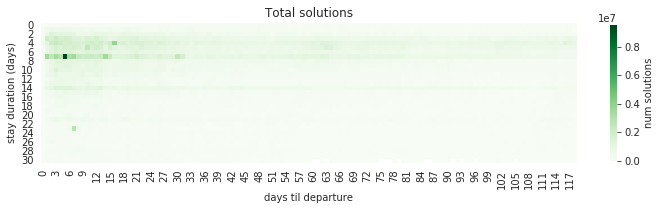

In [26]:
with sns.axes_style("white"):
#     plt.subplot(2,1,1)
    plt.figure(figsize=(12,5))
    sns.heatmap(pvt1, cmap='Greens', square=True,
                vmin=0,
                cbar_kws={'label': 'num solutions',
                        'shrink': 0.5});
    plt.title("Total solutions");
    plt.ylabel("stay duration (days)")
    plt.xlabel("days til departure");

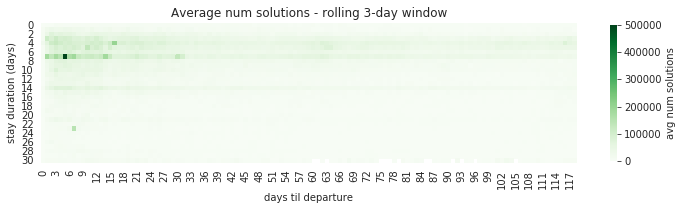

In [27]:
with sns.axes_style("white"):
#     plt.subplot(2,1,2)
    plt.figure(figsize=(12,5))
    sns.heatmap(pvt2, cmap='Greens', square=True,
                vmin=0, #vmax=1.0,
                cbar_kws={'label': 'avg num solutions',
                        'shrink': 0.5});
    plt.title("Average num solutions - rolling 3-day window");
    plt.ylabel("stay duration (days)")
    plt.xlabel("days til departure");

In [28]:
market_agg_pdf_dt = (market_pdf
                .groupby(["outDeptDt_dt", "stay_duration"])
                .agg({"shop_ind": "sum", 
                        "avg_shop_days": "mean",
                        "sum_solution_counts": ["sum", "mean"]
                    })
                )
market_agg_pdf_dt.columns = ["num_shop_days", "avg_pct_coverage_shop", "total_num_solutions", "avg_num_solutions"]
market_agg_pdf_dt = market_agg_pdf_dt.reset_index()


pvt3 = market_agg_pdf_dt.pivot(index="stay_duration", 
                        columns="outDeptDt_dt", 
                        values="total_num_solutions")

pvt4 = market_agg_pdf_dt.pivot(index="stay_duration", 
                       columns="outDeptDt_dt", 
                       values="avg_num_solutions")

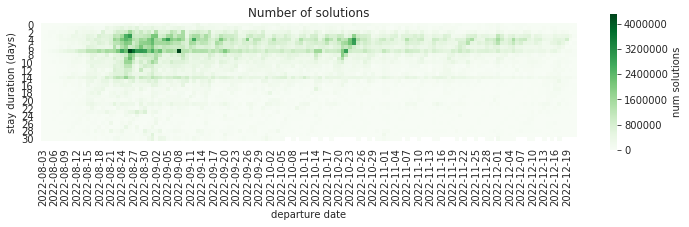

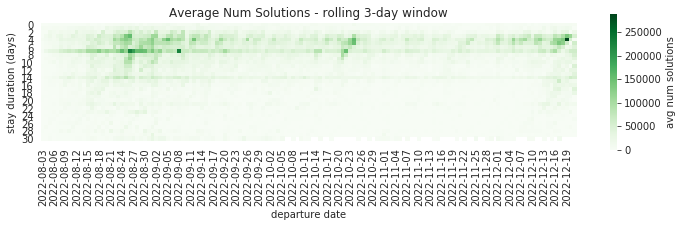

In [31]:
with sns.axes_style("white"):
#     plt.subplot(2,1,1)
    plt.figure(figsize=(12,5))
    sns.heatmap(pvt3, cmap='Greens', square=True,
                vmin=0,
                cbar_kws={'label': 'num solutions',
                        'shrink': 0.5});
    plt.title("Number of solutions");
    plt.ylabel("stay duration (days)")
    plt.xlabel("departure date");

with sns.axes_style("white"):
#     plt.subplot(2,1,2)
    plt.figure(figsize=(12,5))
    sns.heatmap(pvt4, cmap='Greens', square=True,
                vmin=0, #vmax=1.0,
                cbar_kws={'label': 'avg num solutions',
                        'shrink': 0.5});
    plt.title("Average Num Solutions - rolling 3-day window");
    plt.ylabel("stay duration (days)")
    plt.xlabel("departure date");

# fig1.suptitle(market)
# fig1.tight_layout()
# plt.subplots_adjust(top=0.93, hspace=0.4)
# fig1.show()

A few outliers can skew the graphs

Use `robust` param to address

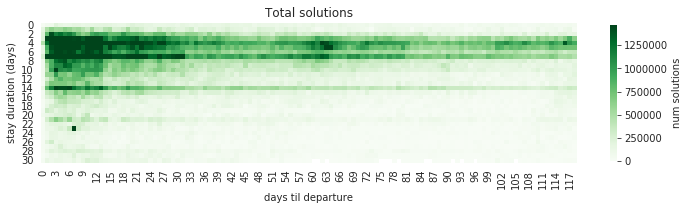

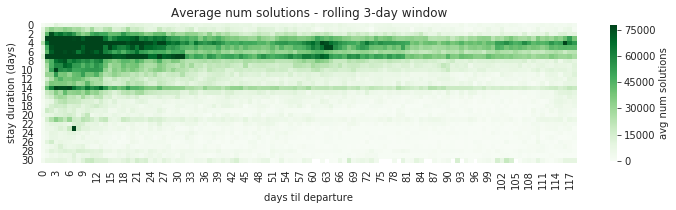

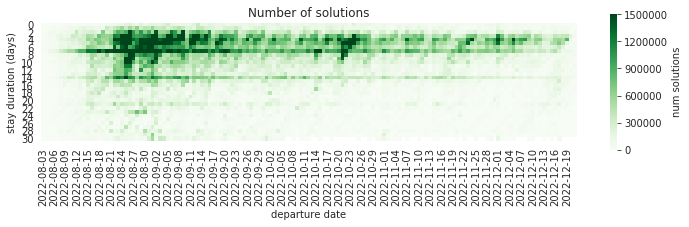

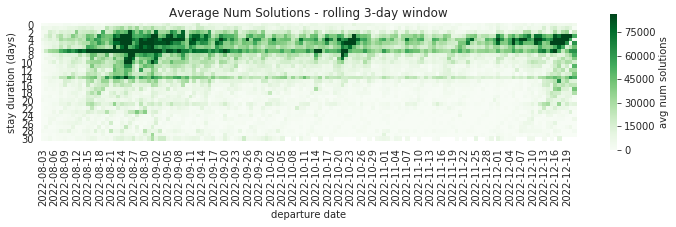

In [35]:
with sns.axes_style("white"):
#     plt.subplot(2,1,1)
    plt.figure(figsize=(12,5))
    sns.heatmap(pvt1, cmap='Greens', square=True,
                vmin=0, robust=True,
                cbar_kws={'label': 'num solutions',
                        'shrink': 0.5});
    plt.title("Total solutions");
    plt.ylabel("stay duration (days)")
    plt.xlabel("days til departure");
    
with sns.axes_style("white"):
#     plt.subplot(2,1,2)
    plt.figure(figsize=(12,5))
    sns.heatmap(pvt2, cmap='Greens', square=True,
                vmin=0, robust=True,
                cbar_kws={'label': 'avg num solutions',
                        'shrink': 0.5});
    plt.title("Average num solutions - rolling 3-day window");
    plt.ylabel("stay duration (days)")
    plt.xlabel("days til departure");
    
with sns.axes_style("white"):
#     plt.subplot(2,1,1)
    plt.figure(figsize=(12,5))
    sns.heatmap(pvt3, cmap='Greens', square=True,
                vmin=0, robust=True,
                cbar_kws={'label': 'num solutions',
                        'shrink': 0.5});
    plt.title("Number of solutions");
    plt.ylabel("stay duration (days)")
    plt.xlabel("departure date");

with sns.axes_style("white"):
#     plt.subplot(2,1,2)
    plt.figure(figsize=(12,5))
    sns.heatmap(pvt4, cmap='Greens', square=True,
                vmin=0, robust=True,
                cbar_kws={'label': 'avg num solutions',
                        'shrink': 0.5});
    plt.title("Average Num Solutions - rolling 3-day window");
    plt.ylabel("stay duration (days)")
    plt.xlabel("departure date");

Wait to do this until we have the additional data?

In [41]:


# from 04c notebook
from imghdr import what

"""
See `preprocess-to-plot.py` for preprocessing that generates `market_pdf`, 
the inputs for our plotting function.
"""


def agg_and_plot(market, market_pdf, what_to_plot="shops", save_fig=False):
    """
    params:
    --------
    what_to_plot (str): ["shops", "vol", "both"]
    """
    # AGGREGATE DATA
    agg_cols = ["num_shop_days", "avg_pct_coverage_shop", 
                "total_num_solutions", "avg_num_solutions"] 
    agg_dict = {"shop_ind": "sum", 
                            "avg_shop_days": "mean",
                            "sum_solution_counts": ["sum", "mean"]
                        }

    agg_dtd = (market_pdf
                    .groupby(["days_til_dept", "stay_duration"])
                    .agg(agg_dict)
                )
    agg_dtd.columns = agg_cols
    agg_dtd = agg_dtd.reset_index()

    agg_dept_dt = (market_pdf
                    .groupby(["outDeptDt_dt", "stay_duration"])
                    .agg(agg_dict)
                )
    agg_dept_dt.columns = agg_cols
    agg_dept_dt = agg_dept_dt.reset_index()


    # PIVOT & PLOT
    file_name = (market + "_shop-dts_" + shop_start_str + "_" + shop_end_str 
                + "_travel-dtd_" + str(max_days_til_dept) + "-days")

    # number of shop days -- a boolean
    if what_to_plot in ["shops", "both"]:
        file_name += "_shop-bool"

        pvt1 = agg_dept_dt.pivot(index="stay_duration", 
                                columns="outDeptDt_dt", 
                                values="num_shop_days")

        pvt2 = agg_dept_dt.pivot(index="stay_duration", 
                            columns="outDeptDt_dt", 
                            values="avg_pct_coverage_shop")

        pvt3 = agg_dtd.pivot(index="stay_duration", 
                            columns="days_til_dept", 
                            values="num_shop_days")

        pvt4 = agg_dtd.pivot(index="stay_duration", 
                            columns="days_til_dept", 
                            values="avg_pct_coverage_shop")

        # vs departure date
        fig1, _ = plt.subplots(2,1, figsize=(max_days_til_dept//5, (max_stay_duration//6)*2))
        with sns.axes_style("white"):
            plt.subplot(2,1,1)
            sns.heatmap(pvt1, cmap='Greens', square=True,
                        vmin=0,
                        cbar_kws={'label': 'number days w/ a shop',
                                'shrink': 0.5});
            plt.title("Total num shop days");
            plt.ylabel("stay duration (days)")
            plt.xlabel("departure date");

        with sns.axes_style("white"):
            plt.subplot(2,1,2)
            sns.heatmap(pvt2, cmap='Greens', square=True,
                        vmin=0, vmax=1.0,
                        cbar_kws={'label': 'avg % coverage',
                                'shrink': 0.5});
            plt.title("Average % Coverage - rolling 3-day window of shopping");
            plt.ylabel("stay duration (days)")
            plt.xlabel("departure date");
            
        fig1.suptitle(market)
        fig1.tight_layout()
        plt.subplots_adjust(top=0.93, hspace=0.4)
        fig1.show()

        if save_fig:
            plt.savefig(out_dir + file_name + "_by-dept-date.png", format="png")


        # vs days til dept
        fig2, _ = plt.subplots(2,1, figsize=(max_days_til_dept//5, (max_stay_duration//6)*2))
        with sns.axes_style("white"):
            plt.subplot(2,1,1)
            sns.heatmap(pvt3, cmap='Greens', square=True,
                        vmin=0,
                        cbar_kws={'label': 'num shop days',
                                'shrink': 0.5});
            plt.title("Num shop days");
            plt.ylabel("stay duration (days)")
            plt.xlabel("days until departure");

        with sns.axes_style("white"):
            plt.subplot(2,1,2)
            sns.heatmap(pvt4, cmap='Greens', square=True,
                        vmin=0, vmax=1.0,
                        cbar_kws={'label': 'avg % coverage (shop days)',
                                'shrink': 0.5});
            plt.title("Average % Coverage - rolling 3-day window");
            plt.ylabel("stay duration (days)")
            plt.xlabel("days until departure");

        fig2.suptitle(market)
        fig2.tight_layout()
        plt.subplots_adjust(top=0.93, hspace=0.3)
        fig2.show()

        if save_fig:
            plt.savefig(out_dir + file_name + "_by-days-til-dept.png", format="png")
    

    # number of solutions
    if what_to_plot in ["vol", "both"]:
        file_name += "_num-sol"

        pvt1 = agg_dept_dt.pivot(index="stay_duration", 
                                columns="outDeptDt_dt", 
                                values="total_num_solutions")

        pvt2 = agg_dept_dt.pivot(index="stay_duration", 
                            columns="outDeptDt_dt", 
                            values="avg_num_solutions")

        pvt3 = agg_dtd.pivot(index="stay_duration", 
                            columns="days_til_dept", 
                            values="total_num_solutions")

        pvt4 = agg_dtd.pivot(index="stay_duration", 
                            columns="days_til_dept", 
                            values="avg_num_solutions")


        # vs dept date
        fig1, _ = plt.subplots(2,1, figsize=(max_days_til_dept//5, (max_stay_duration//6)*2))
        with sns.axes_style("white"):
            plt.subplot(2,1,1)
            sns.heatmap(pvt1, cmap='Greens', square=True,
                        vmin=0, robust=True,
                        cbar_kws={'label': 'num solutions',
                                'shrink': 0.5});
            plt.title("Total number of solutions");
            plt.ylabel("stay duration (days)")
            plt.xlabel("departure date");

        with sns.axes_style("white"):
            plt.subplot(2,1,2)
            sns.heatmap(pvt2, cmap='Greens', square=True,
                        vmin=0, robust=True,
                        cbar_kws={'label': 'avg num solutions',
                                'shrink': 0.5});
            plt.title("Average number solutions - rolling 3-day window");
            plt.ylabel("stay duration (days)")
            plt.xlabel("departure date");

        fig1.suptitle(market)
        fig1.tight_layout()
        plt.subplots_adjust(top=0.93, hspace=0.4)
        fig1.show()

        if save_fig:
            plt.savefig(out_dir + file_name + "_by-dept-date.png", format="png")

        # vs days til dept
        fig2, _ = plt.subplots(2,1, figsize=(max_days_til_dept//5, (max_stay_duration//6)*2))
        with sns.axes_style("white"):
            plt.subplot(2,1,1)
            sns.heatmap(pvt3, cmap='Greens', square=True,
                        vmin=0, robust=True,
                        cbar_kws={'label': 'num solutions',
                                'shrink': 0.5});
            plt.title("Total number of solutions");
            plt.ylabel("stay duration (days)")
            plt.xlabel("days until departure");

        with sns.axes_style("white"):
            plt.subplot(2,1,2)
            sns.heatmap(pvt4, cmap='Greens', square=True,
                        vmin=0, robust=True,
                        cbar_kws={'label': 'avg num solutions',
                                'shrink': 0.5});
            plt.title("Average number solutions - rolling 3-day window");
            plt.ylabel("stay duration (days)")
            plt.xlabel("days until departure");
            

        fig2.suptitle(market)
        fig2.tight_layout()
        plt.subplots_adjust(top=0.93, hspace=0.3)
        fig2.show()

        if save_fig:
            plt.savefig(out_dir + file_name + "_by-days-til-dept.png", format="png")

In [37]:
markets_to_plot = [
    'LHR-JFK',
    'JFK-LHR',
    'DFW-ORD',
    'JFK-LAX',
    'BKK-SIN',
    'DEL-BOM',
    'SYD-MEL',
    'LHR-BKK',
    'LHR-DOH',
]

Processing LHR-JFK
Processing JFK-LHR
Processing DFW-ORD
Processing JFK-LAX
Processing BKK-SIN
Processing DEL-BOM
Processing SYD-MEL
Processing LHR-BKK
Processing LHR-DOH


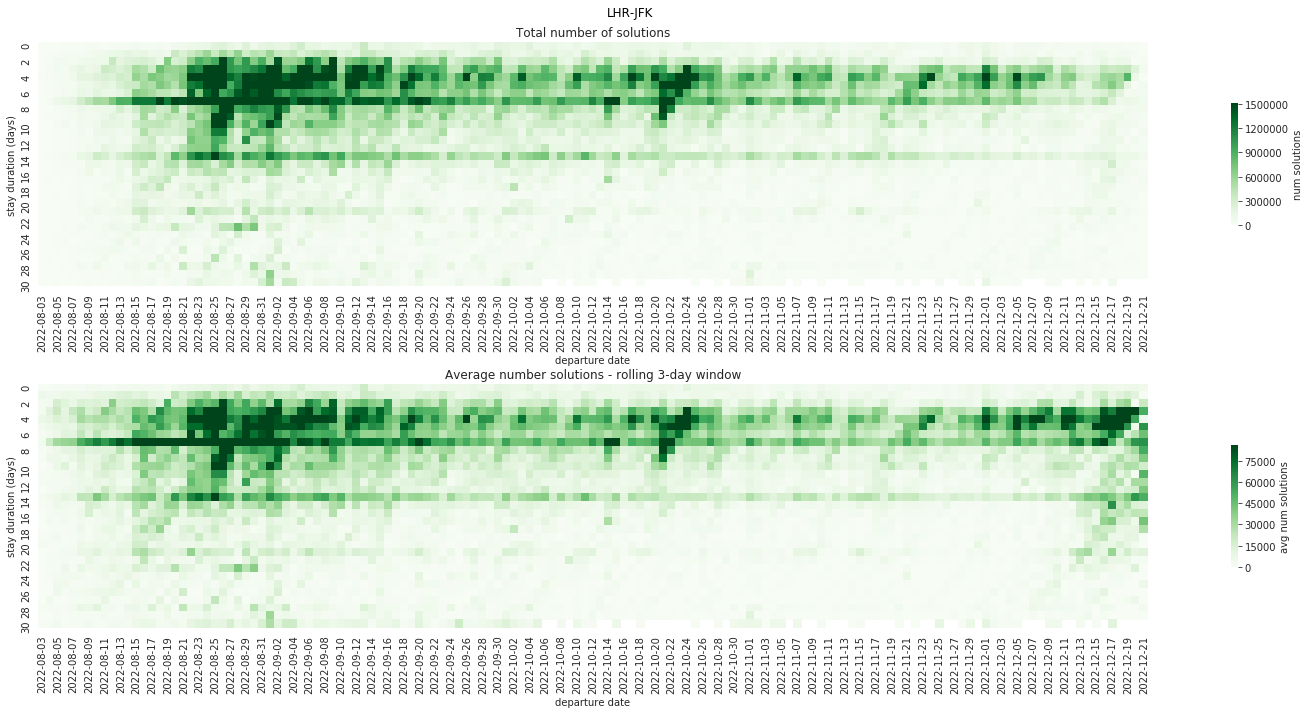

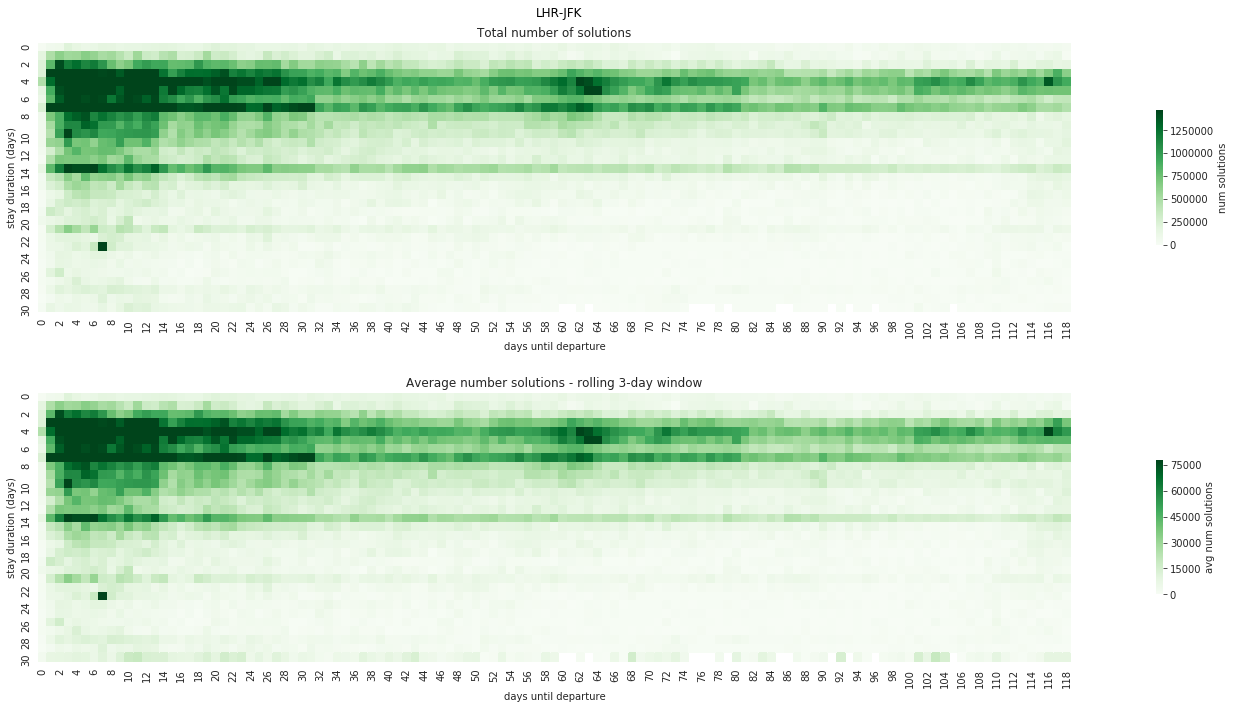

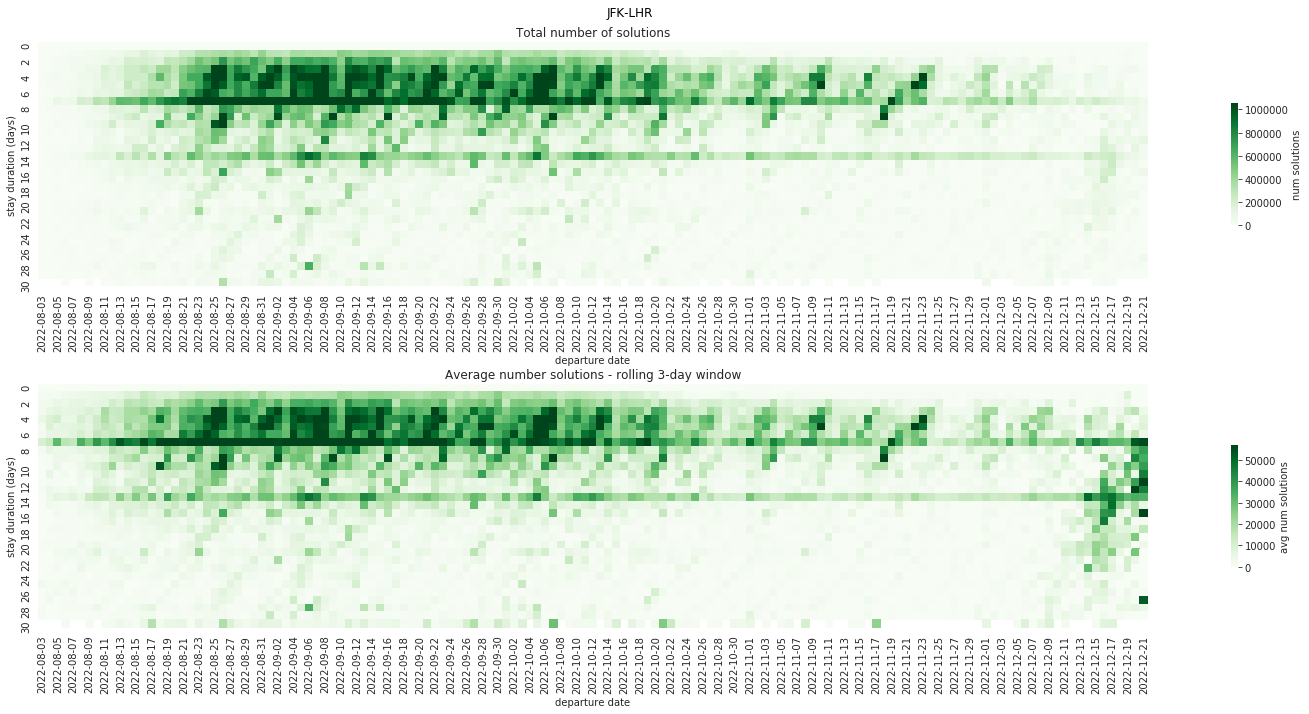

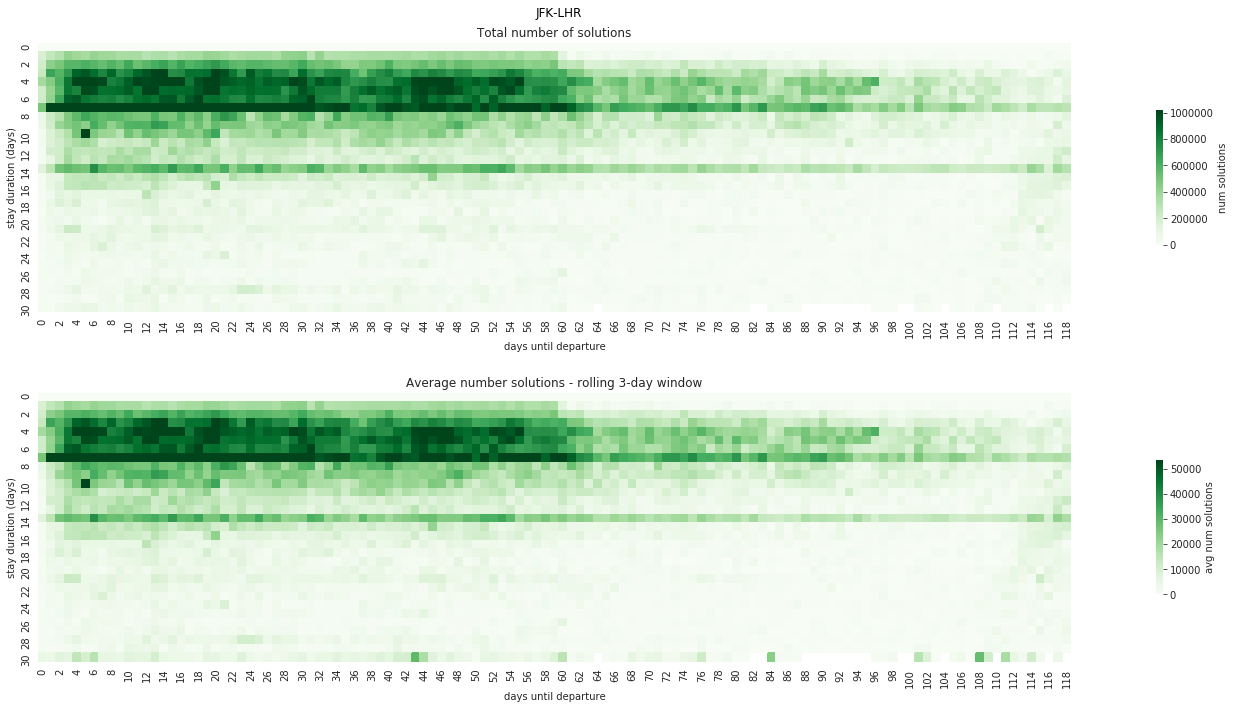

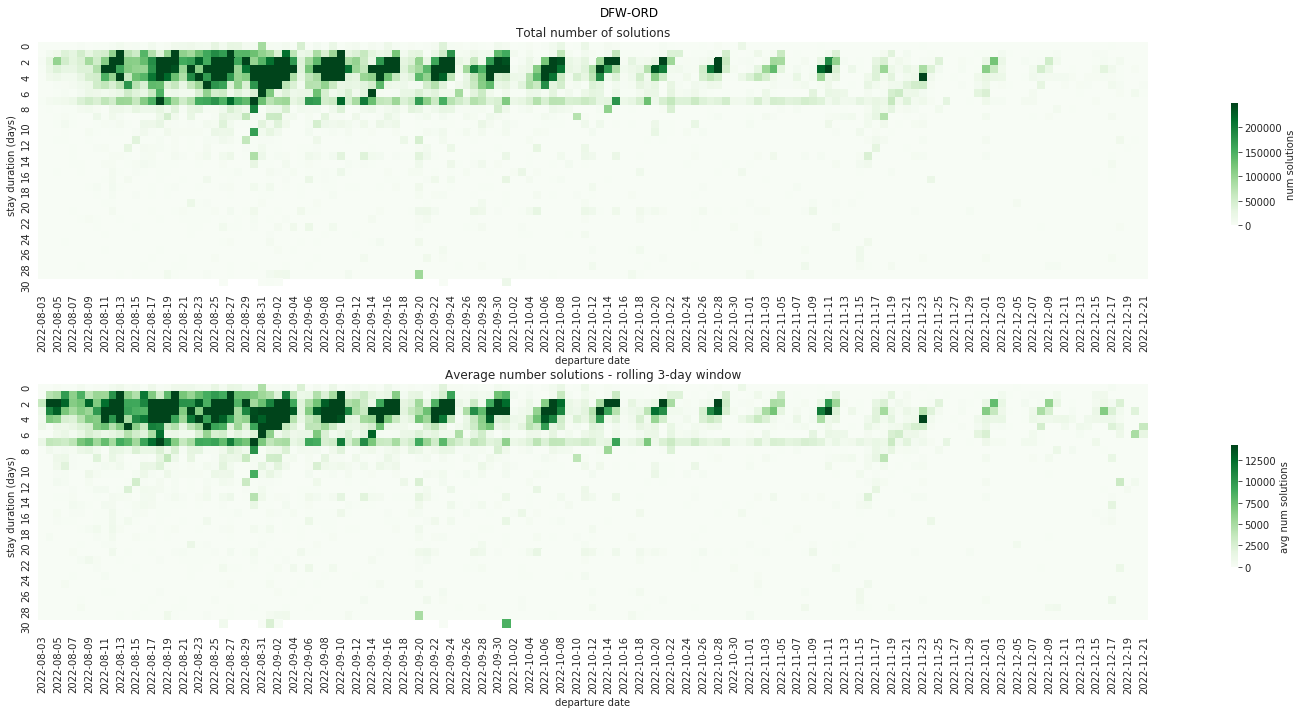

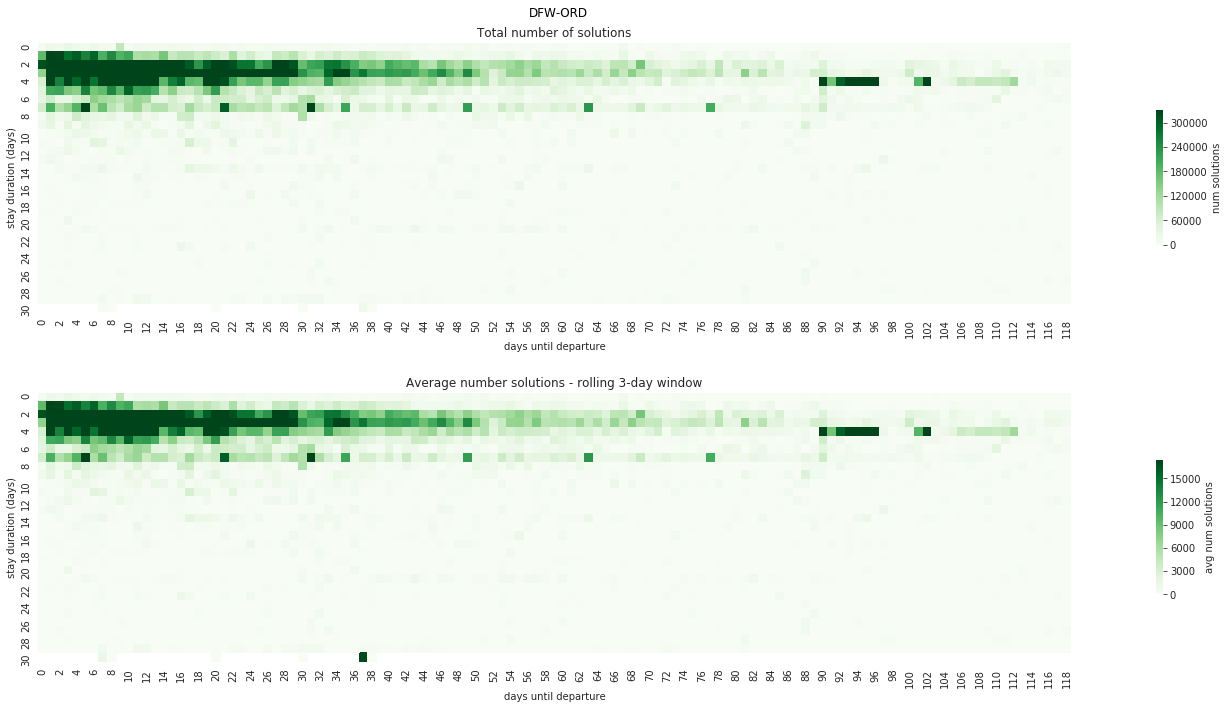

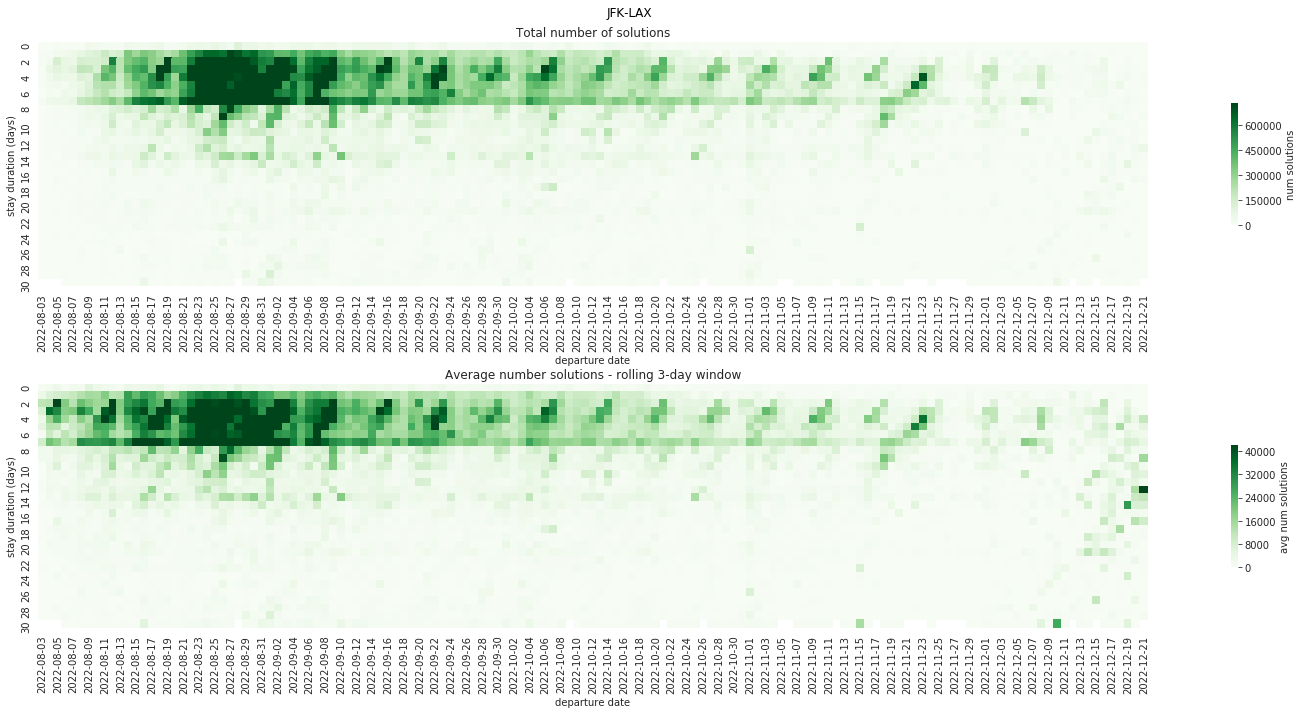

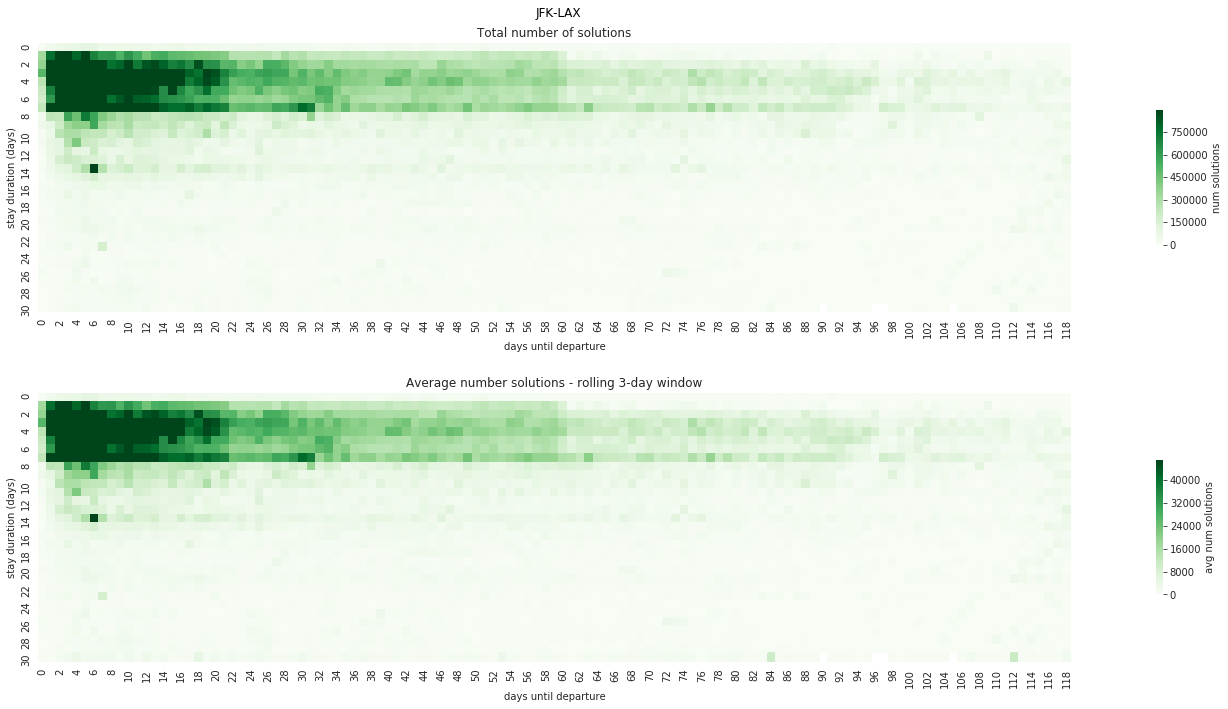

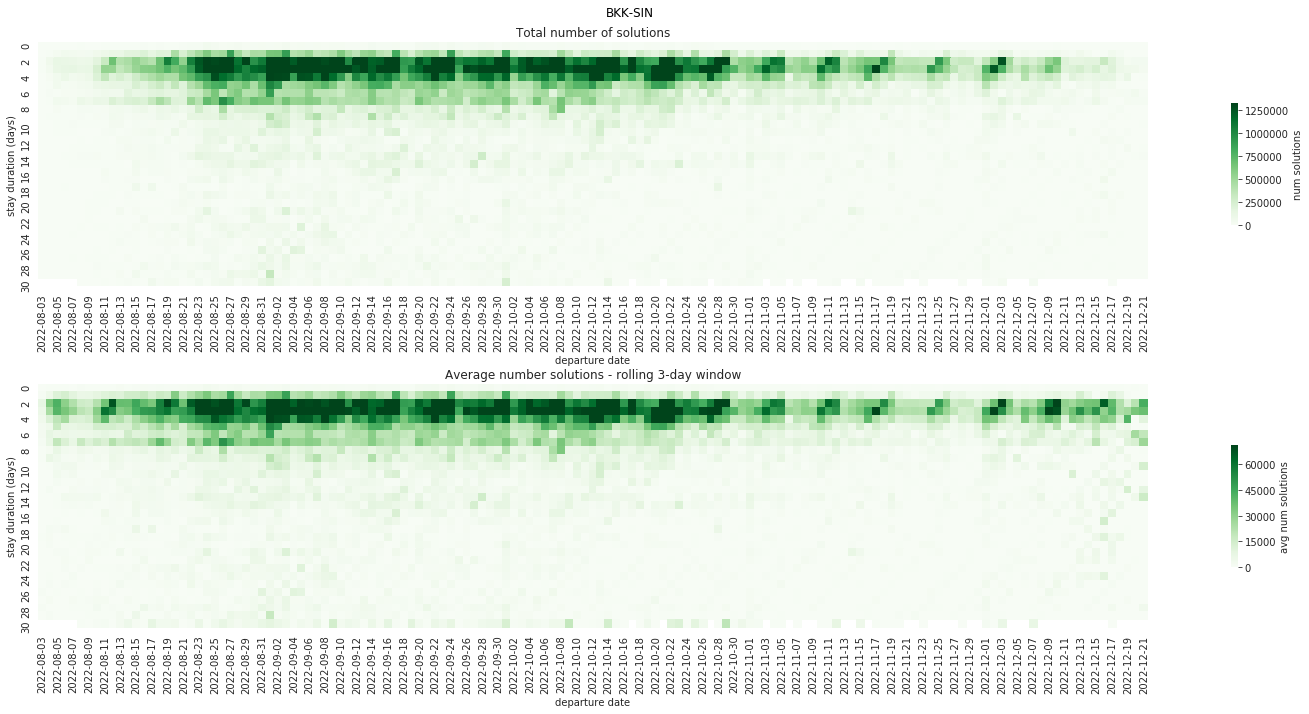

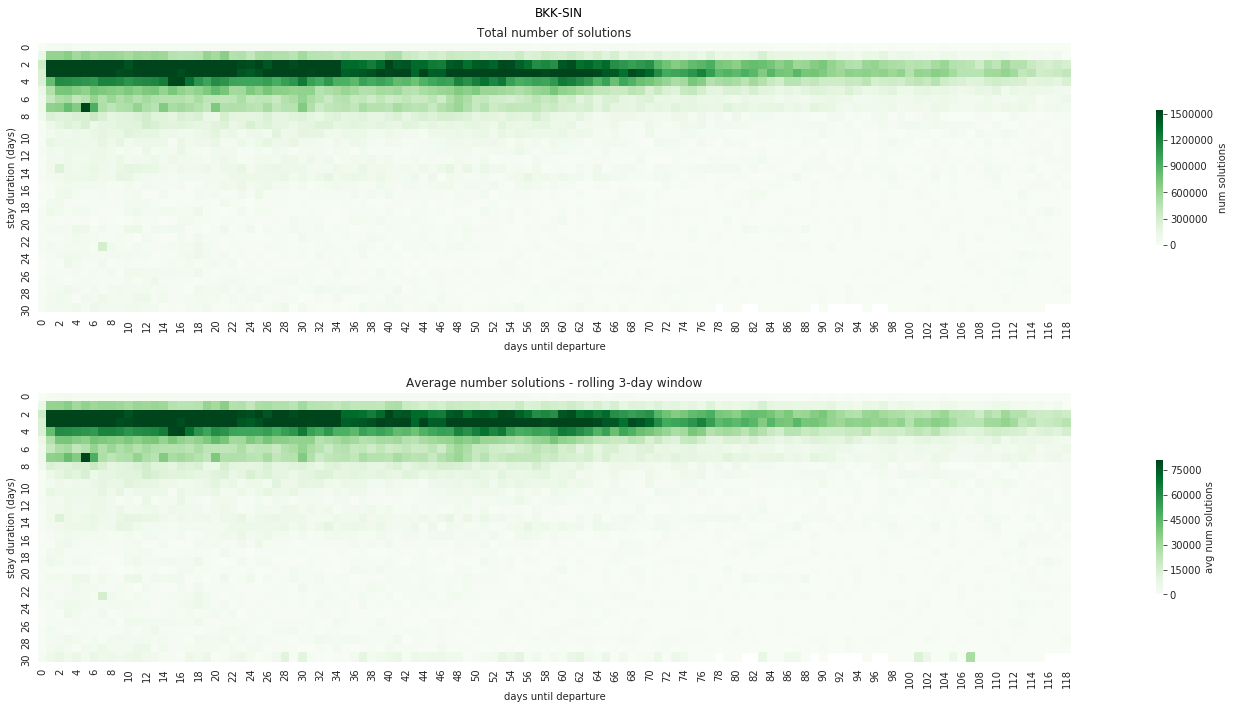

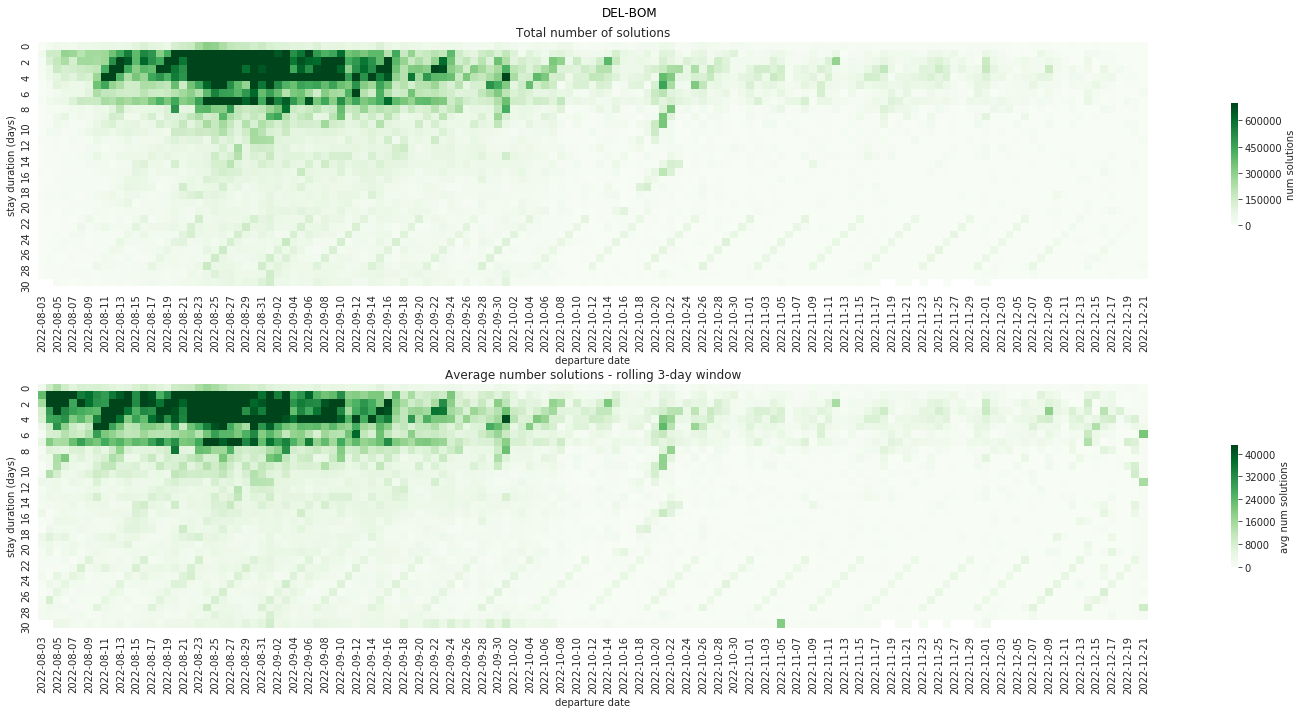

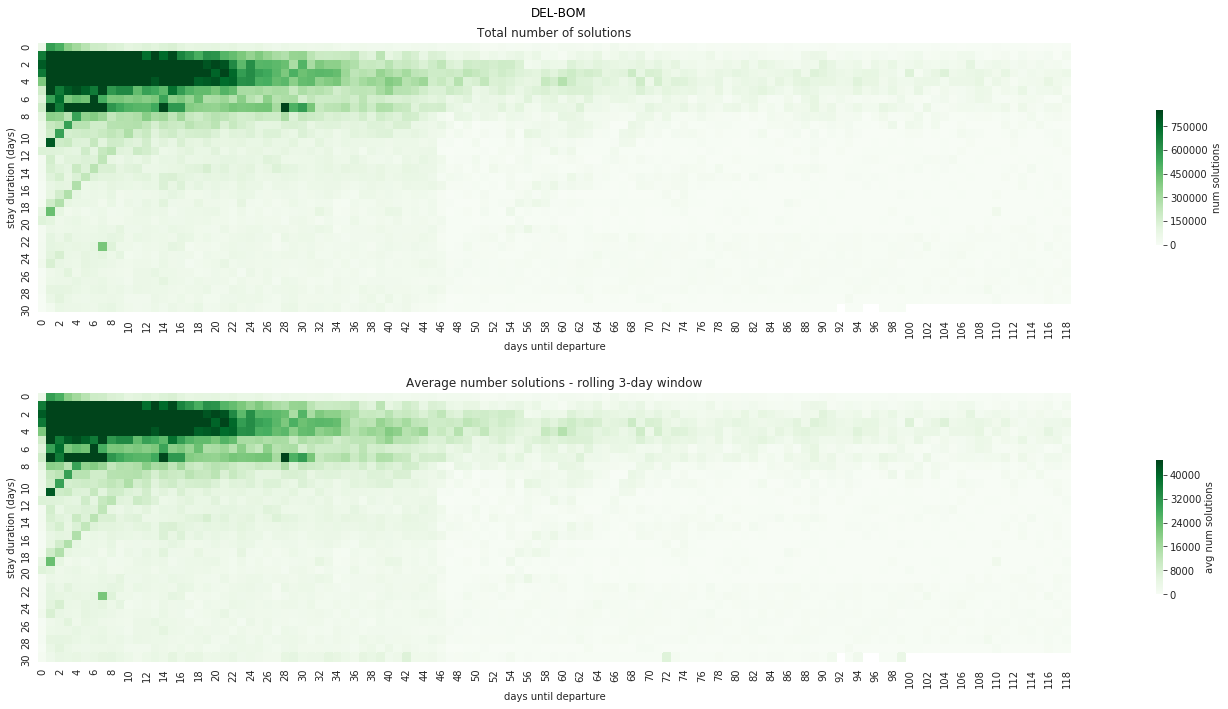

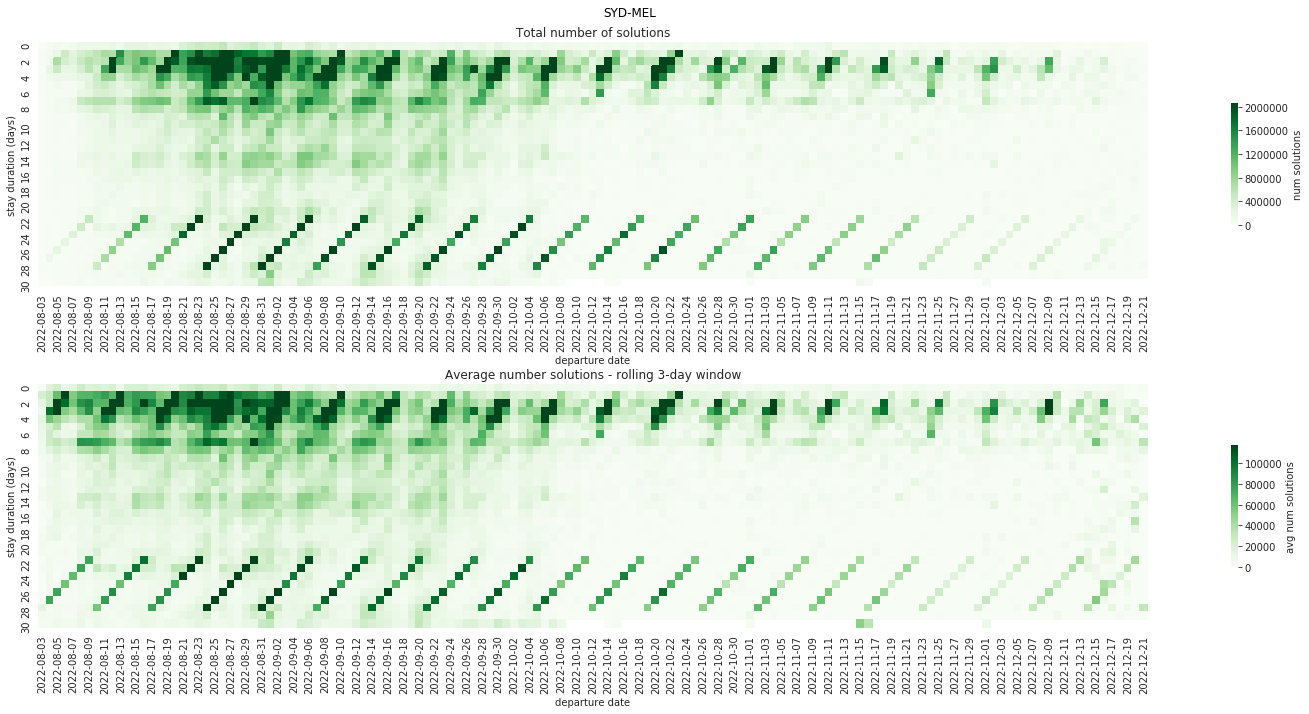

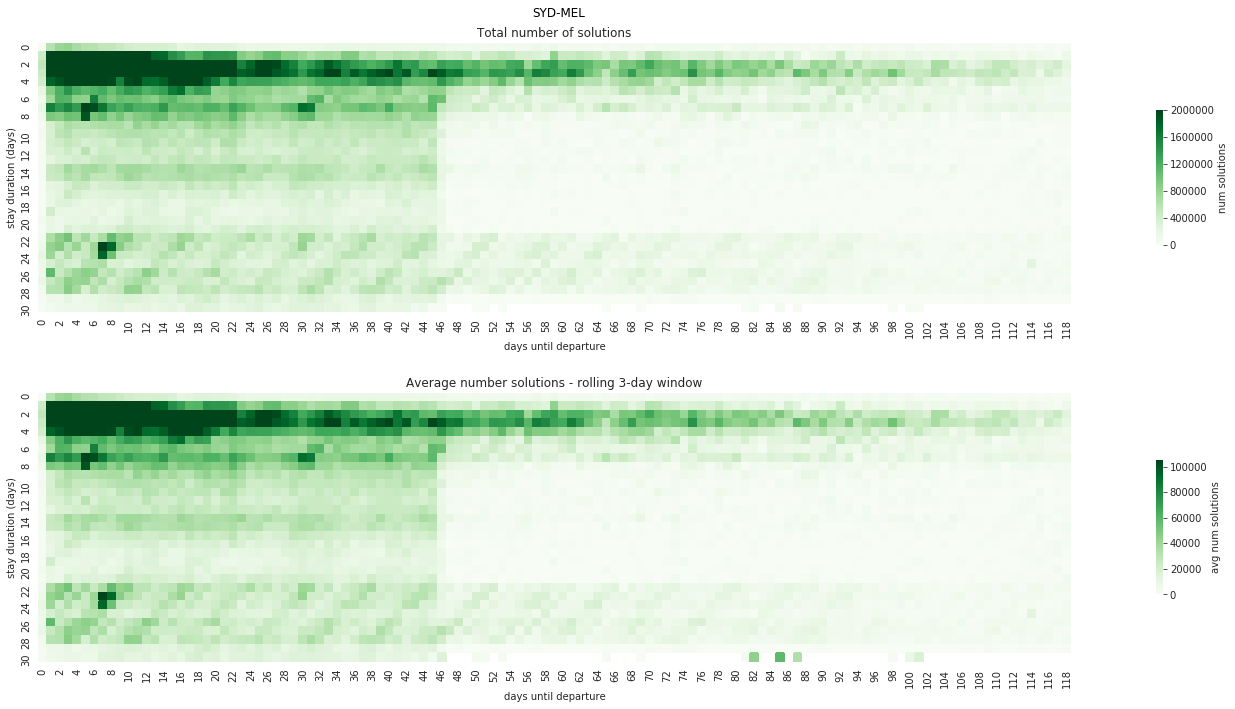

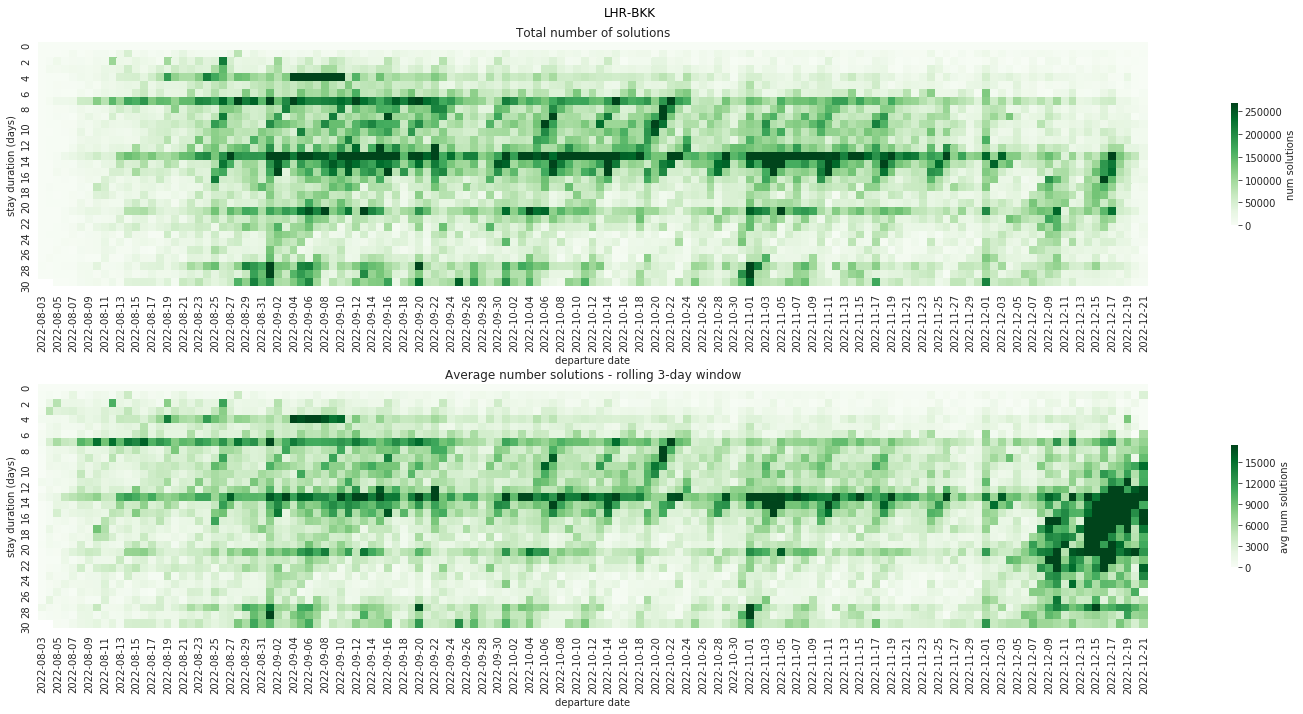

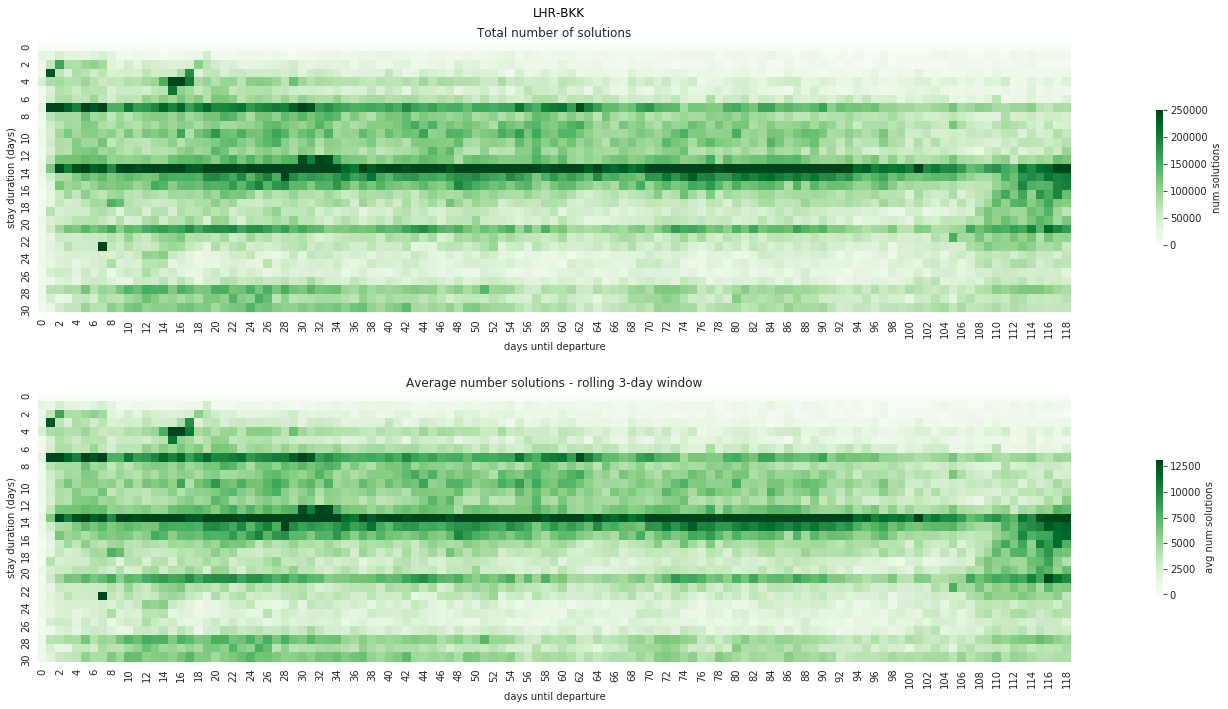

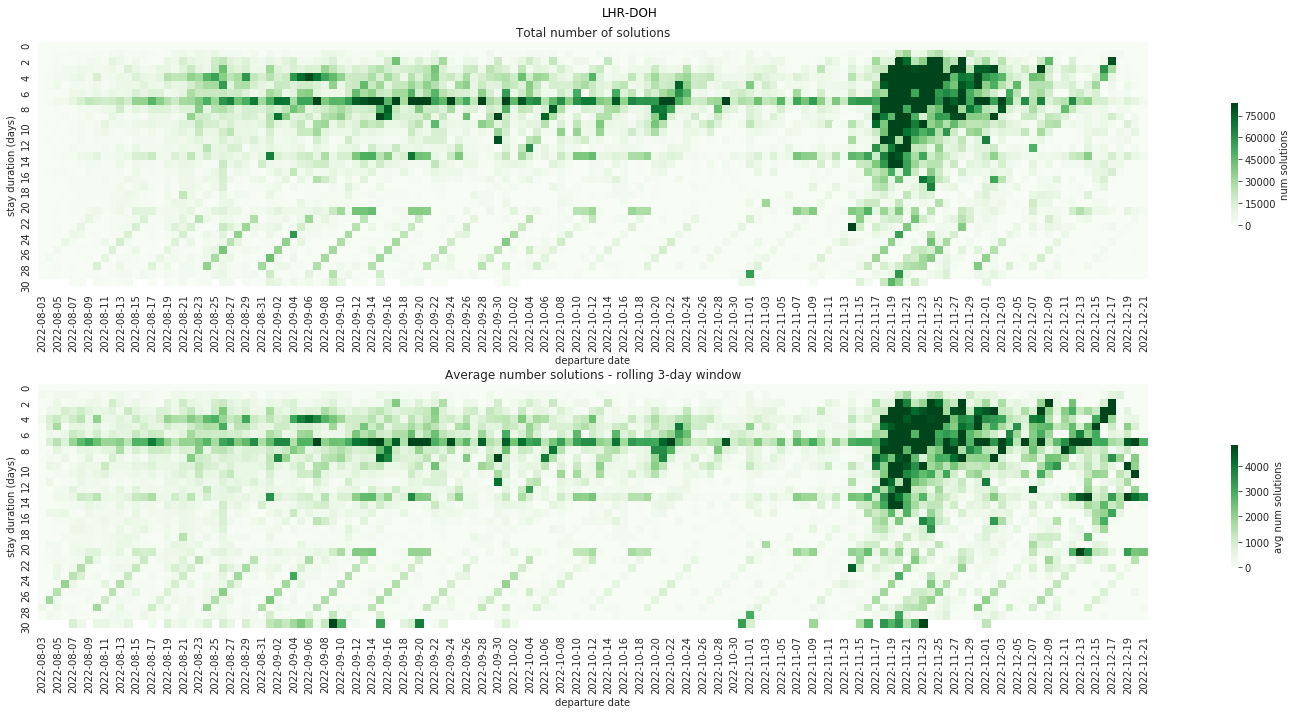

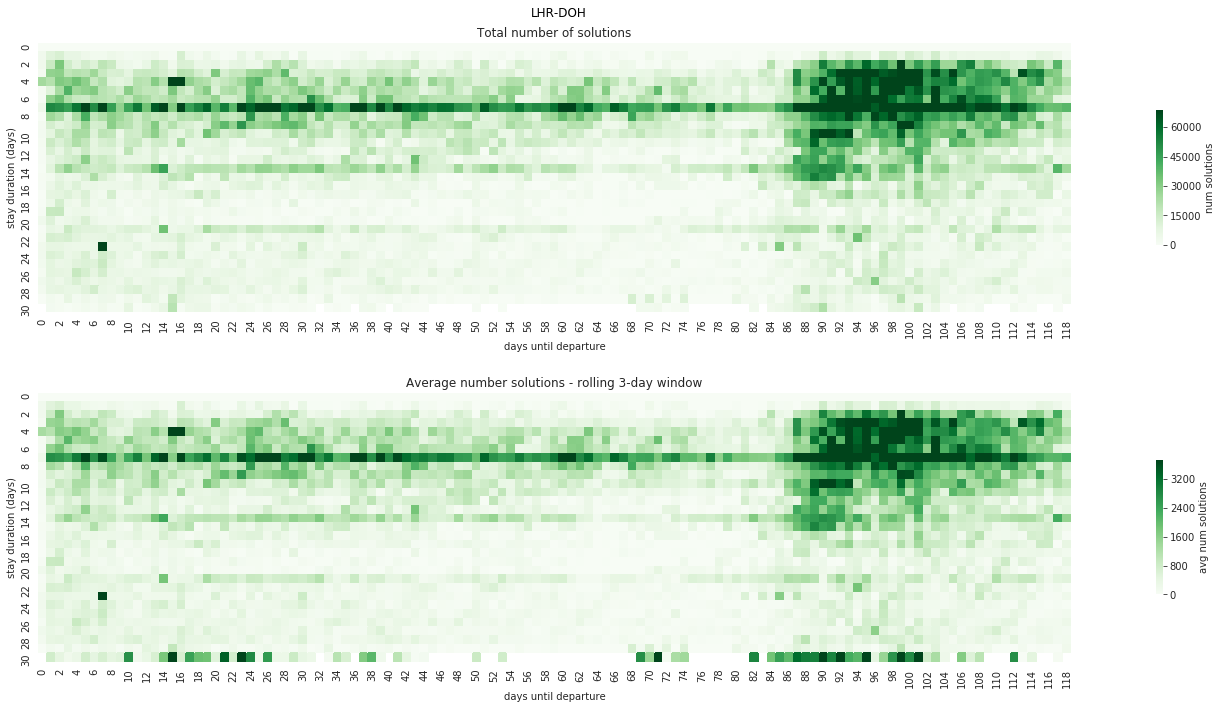

In [42]:
# loop and save "volume" graphs
for market in markets_to_plot:
    print(f"Processing {market}")
    mpdf = process(market, cnt_df)
    agg_and_plot(market, mpdf, what_to_plot="vol", save_fig=True)